# 1. Advanced LSTM (Full Dataset)

## 1.1 Import of packages, dataset and decision point map

In [26]:
# --- Standard Library ---
import os
import sys
import importlib
import re


# --- Third-Party Packages ---
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

# ── Data & Visualization ─────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PM4Py (BPMN handling)
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.objects.conversion.bpmn.variants import to_petri_net

# --- TensorFlow / Keras ---
from tensorflow.keras.optimizers import Adam

# --- Scikit-learn ---
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

# --- Project Utilities ---
# Add FINAL/code to sys.path to import custom functions
code_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "code"))
sys.path.insert(0, code_dir)

from preprocess import extract_bpmn_decision_point_map

from train import (
    prepare_sequences_and_labels,
    prepare_context_attributes,
    build_lstm_model_advanced,
    train_model_advanced,
    tune_hyperparameters_for_dp
)
from evaluate import (
    evaluate_baseline,
    compare_f1_for_trained_model,
    add_unknown_label,
    permutation_importance_context,
    permutation_importance_all_features,
    plot_feature_importance
)

In [2]:
# Import BPMN-File
bpmn_model = bpmn_importer.apply("../resources/loan_application.bpmn")

# Convert BPMN to Petri net
net, im, fm = to_petri_net.apply(bpmn_model)

bpmn_decision_point_map = extract_bpmn_decision_point_map(bpmn_model)

In [3]:
# Path relative to current working directory
path = "../data/processed/dp_split_datasets_full_advanced.joblib"

dp_split_datasets_full_advanced = joblib.load(path)

print("Loaded type:", type(dp_split_datasets_full_advanced))
print("Top-level keys:", list(dp_split_datasets_full_advanced.keys())[:5])

Loaded type: <class 'dict'>
Top-level keys: ['DP 1', 'DP 3', 'DP 4', 'DP 5', 'DP 7']


## 1.2 Training for each decision point and prediction Test-Set

In [4]:
# --- Storage ---
accuracy_per_class = []
baseline_accuracy_per_class = []
decision_point_models_advanced = {}

# --- Parameters ---
context_keys_advanced = [
    "case:LoanGoal",
    "case:ApplicationType",
    "case:RequestedAmount",
    "position_in_trace",
    "day_of_week",
    "time_of_day",
    "month",
    "week_of_year",
    "is_weekend",
    "is_holiday_nl",
    "time_since_case_start",
    "time_since_prev_event",
    "n_repeats_current_activity",
    "n_unique_activities",
    "immediate_loop",
    "n_total_repeats",
    "longest_repeat_streak"
]

for decision_point in bpmn_decision_point_map:
    print(f"\n=== [ADVANCED LSTM] Training {decision_point} ===")

    try:
        splits = dp_split_datasets_full_advanced.get(decision_point)
        if not splits:
            print(f"No split data for {decision_point}")
            continue

        df_train = splits["train"]
        df_test = splits["test"]
        df_combined = pd.concat([df_train, df_test], ignore_index=True)

        # --- Prepare sequences ---
        X_acts_padded, X_durs_padded, X_res_padded, activity_encoder, resource_encoder, label_encoder, y_all, max_seq_len = prepare_sequences_and_labels(df_combined)

        # Add "UNKNOWN" to encoders if missing
        if "UNKNOWN" not in resource_encoder.classes_:
            resource_encoder.classes_ = np.append(resource_encoder.classes_, "UNKNOWN")
        if "UNKNOWN" not in activity_encoder.classes_:
            activity_encoder.classes_ = np.append(activity_encoder.classes_, "UNKNOWN")

        # --- Prepare context features ---
        X_context_array, context_dim, context_encoders = prepare_context_attributes(df_combined, context_keys_advanced)

        # --- Train/Test split indices ---
        train_idx = df_train.index.tolist()
        test_idx = df_test.index.tolist()

        X_train = [X_acts_padded[train_idx], X_durs_padded[train_idx], X_res_padded[train_idx], X_context_array[train_idx]]
        y_train = y_all[train_idx]

        X_test = [X_acts_padded[test_idx], X_durs_padded[test_idx], X_res_padded[test_idx], X_context_array[test_idx]]
        y_test = y_all[test_idx]

        # --- Build model ---
        model = build_lstm_model_advanced(
            num_activities=len(activity_encoder.classes_),
            num_resources=len(resource_encoder.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=len(label_encoder.classes_)
        )

        # --- Train model ---
        model = train_model_advanced(
            model=model,
            X_train=X_train,
            y_train=y_train,
            label_encoder=label_encoder
        )

        # --- Predict and evaluate ---
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)


        lstm_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
        baseline_report = evaluate_baseline(y_test, label_encoder)  # If using dist baseline now

        print(f"\n--- [ADVANCED LSTM] Results for {decision_point} ---")
        for label in label_encoder.classes_:
            if label in lstm_report:
                print(f"{label}: Precision={lstm_report[label]['precision']:.2f}, Recall={lstm_report[label]['recall']:.2f}, F1={lstm_report[label]['f1-score']:.2f}")

        # --- Store per-class results ---
        for label in label_encoder.classes_:
            if label in lstm_report:
                accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(lstm_report[label]["precision"] * 100, 2),
                    "recall": round(lstm_report[label]["recall"] * 100, 2),
                    "f1_score": round(lstm_report[label]["f1-score"] * 100, 2),
                    "support": lstm_report[label]["support"]
                })
            if label in baseline_report:
                baseline_accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(baseline_report[label]["precision"] * 100, 2),
                    "recall": round(baseline_report[label]["recall"] * 100, 2),
                    "f1_score": round(baseline_report[label]["f1-score"] * 100, 2),
                    "support": baseline_report[label]["support"]
                })

        # --- Save model and encoders ---
        decision_point_models_advanced[decision_point] = {
            "model": model,
            "activity_encoder": activity_encoder,
            "resource_encoder": resource_encoder,
            "label_encoder": label_encoder,
            "context_keys": context_keys_advanced,
            "context_encoders": context_encoders,
            "max_seq_len": max_seq_len
        }

    except Exception as e:
        print(f"Error while training {decision_point}: {e}")


=== [ADVANCED LSTM] Training DP 1 ===
Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6975 - loss: 0.8743 - val_accuracy: 0.9878 - val_loss: 0.0948
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.1999 - val_accuracy: 0.9995 - val_loss: 0.0059
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0305 - val_accuracy: 1.0000 - val_loss: 7.3139e-04
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 3.8274e-04
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 1.1364e-04
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 4.3846e-05
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- [ADVANCED LSTM] Results for DP 1 ---
A_Concept: 

In [5]:
# Convert results to DataFrames
df_accuracy = pd.DataFrame(accuracy_per_class)
df_baseline = pd.DataFrame(baseline_accuracy_per_class)

# Calculate total support per decision point (for per-DP percentage if needed)
total_support_per_dp = df_accuracy.groupby("decision_point")["support"].transform("sum")
df_accuracy["support_percentage"] = round(df_accuracy["support"] / total_support_per_dp * 100, 2)

# --- Overall Weighted Metrics ---
weighted_precision_lstm = (df_accuracy["precision"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_recall_lstm = (df_accuracy["recall"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_f1_lstm = (df_accuracy["f1_score"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()

weighted_precision_majority = (df_baseline["precision"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_recall_majority = (df_baseline["recall"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_f1_majority = (df_baseline["f1_score"] * df_baseline["support"]).sum() / df_baseline["support"].sum()

# Relative improvements
relative_improvement_f1 = (weighted_f1_lstm - weighted_f1_majority) / weighted_f1_majority * 100
relative_improvement_precision = (weighted_precision_lstm - weighted_precision_majority) / weighted_precision_majority * 100
relative_improvement_recall = (weighted_recall_lstm - weighted_recall_majority) / weighted_recall_majority * 100

# --- Print Global Comparison ---
print("\n=== Global Comparison Across All Decision Points ===")
print(f"Weighted Precision (LSTM):     {weighted_precision_lstm:.3f}")
print(f"Weighted Precision (Majority): {weighted_precision_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_precision:.2f}%\n")

print(f"Weighted Recall (LSTM):        {weighted_recall_lstm:.3f}")
print(f"Weighted Recall (Majority):    {weighted_recall_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_recall:.2f}%\n")

print(f"Weighted F1 (LSTM):            {weighted_f1_lstm:.3f}")
print(f"Weighted F1 (Majority):        {weighted_f1_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_f1:.2f}%")


=== Global Comparison Across All Decision Points ===
Weighted Precision (LSTM):     89.736
Weighted Precision (Majority): 40.554
Relative Improvement:          121.28%

Weighted Recall (LSTM):        71.097
Weighted Recall (Majority):    40.574
Relative Improvement:          75.23%

Weighted F1 (LSTM):            76.847
Weighted F1 (Majority):        40.562
Relative Improvement:          89.46%


## 1.3 Hyperparameter-Tuning for Low-Performing Models

In [7]:
# Compute weighted F1-score per decision point without including the grouping column
dp_weighted_f1 = (
    df_accuracy
    .groupby("decision_point")
    .apply(lambda g: (g["f1_score"] * g["support"]).sum() / g["support"].sum(), include_groups=False)
    .reset_index(name="weighted_f1")
)

# Filter decision points below 80%
underperforming_dps = dp_weighted_f1[dp_weighted_f1["weighted_f1"] < 85]
low_accuracy_dps = underperforming_dps["decision_point"].tolist()

print("Decision Points with Weighted F1-score < 85%:\n")
print(underperforming_dps)
print(len(underperforming_dps))

Decision Points with Weighted F1-score < 85%:

   decision_point  weighted_f1
1           DP 10    77.166179
2           DP 11    78.846774
3           DP 12    77.904869
9           DP 19    73.073500
10          DP 20    69.984858
11          DP 21    68.800052
12          DP 22    70.163078
14          DP 25    81.372596
16          DP 27    78.556479
17          DP 28    78.187965
18          DP 29    77.507849
20          DP 30    76.687375
21          DP 31    58.605639
22          DP 32    77.626743
24          DP 34    77.503898
25          DP 35    76.611924
26          DP 36    76.302664
27          DP 37    77.082939
28          DP 39    57.302465
30          DP 40    63.190317
31          DP 41    61.822423
32          DP 42    77.004742
33          DP 43    77.416417
34          DP 44    80.731232
35          DP 46    83.426435
37          DP 48    76.700435
38          DP 49    78.472661
40           DP 7    68.416248
41           DP 8    73.484468
42           DP 9    77

In [8]:
# Store tuned models and their performance
tuned_models = {}

for dp in low_accuracy_dps:
    print(f"\nTuning Decision Point: {dp}")
    
    splits = dp_split_datasets_full_advanced.get(dp)
    if not splits:
        print(f"No data available for {dp}")
        continue

    # Combine train and test data for preprocessing
    df_train = splits["train"]
    df_test = splits["test"]
    df_combined = pd.concat([df_train, df_test], ignore_index=True)

    try:
        # Perform hyperparameter tuning
        best_hp, best_model, label_enc = tune_hyperparameters_for_dp(
            dp_name=dp,
            df=df_combined,
            context_keys=context_keys_advanced,
            max_trials=5,  # Adjust as needed
            executions_per_trial=1,
            target_val_acc=0.9
        )

        # Save the best model and encoder
        tuned_models[dp] = {
            "model": best_model,
            "hyperparameters": best_hp,
            "label_encoder": label_enc
        }

    except Exception as e:
        print(f"Error while tuning {dp}: {e}")

Trial 5 Complete [00h 02m 37s]
val_accuracy: 0.8737452030181885

Best val_accuracy So Far: 0.8817077875137329
Total elapsed time: 00h 12m 45s


/Users/marcohmayer/.pyenv/versions/3.11.8/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# Step 1: Compute weighted F1-scores per decision point
dp_weighted_f1 = (
    df_accuracy
    .groupby("decision_point")
    .apply(lambda g: (g["f1_score"] * g["support"]).sum() / g["support"].sum(), include_groups=False)
    .reset_index(name="weighted_f1")
)

# Convert to dict for fast lookup
dp_f1_dict = dp_weighted_f1.set_index("decision_point")["weighted_f1"].to_dict()

# Step 2: Loop over all DPs and build rows
dp_rows = []
all_decision_points = list(bpmn_decision_point_map.keys())

for dp_name in all_decision_points:
    # Tuned model
    if dp_name in tuned_models:
        model = tuned_models[dp_name]["model"]
        hp = tuned_models[dp_name]["hyperparameters"]
        acc = tuned_models[dp_name].get("final_training_accuracy", None)

        row = {
            "decision_point": dp_name,
            "embedding_dim": hp.get("embedding_dim"),
            "lstm_units": hp.get("lstm_units"),
            "dropout_rate": hp.get("dropout_rate"),
            "learning_rate": round(hp.get("learning_rate"), 6),
        }

    # Non-tuned model → use defaults and fallback to F1
    else:
        fallback_acc = dp_f1_dict.get(dp_name, None)
        row = {
            "decision_point": dp_name,
            "embedding_dim": 64,
            "lstm_units": 128,
            "dropout_rate": 0.3,
            "learning_rate": 0.001,
        }

    dp_rows.append(row)

# Step 3: Create summary DataFrame
df_hyperparams_summary = pd.DataFrame(dp_rows)
df_hyperparams_summary.set_index("decision_point", inplace=True)
df_hyperparams_summary = df_hyperparams_summary.sort_index()
display(df_hyperparams_summary)

,embedding_dim,lstm_units,dropout_rate,learning_rate
decision_point,,,,
DP 1,64,128,0.3,0.001000
DP 10,64,128,0.2,0.001294
DP 11,128,256,0.4,0.001326
DP 12,32,64,0.4,0.003402
DP 13,64,128,0.3,0.001000
DP 14,64,128,0.3,0.001000
DP 15,64,128,0.3,0.001000
DP 16,64,128,0.3,0.001000
DP 17,64,128,0.3,0.001000


## 1.4 Retraining and Final Prediction on Hold-Out-Set

In [17]:
# --- Storage ---
final_holdout_predictions_advanced = {}
accuracy_per_class = []
models_advanced_holdout = {}


# Loop over each decision point
for dp_name in df_hyperparams_summary.index:
    print(f"\nRetraining and predicting holdout for: {dp_name}")

    try:
        # Get data splits
        splits = dp_split_datasets_full_advanced.get(dp_name)
        if not splits or "holdout" not in splits:
            print(f"No holdout set for {dp_name}")
            continue

        # Combine training + test for training
        df_train = pd.concat([splits["train"], splits["test"]], ignore_index=True)
        df_holdout = splits["holdout"]

        # Prepare sequences
        X_acts, X_durs, X_res, act_enc, res_enc, label_encoder, y_train_all, max_seq_len = prepare_sequences_and_labels(df_train)
        X_acts_hold, X_durs_hold, X_res_hold, _, _, _, y_holdout, _ = prepare_sequences_and_labels(df_holdout)

        # Context attributes
        X_ctx_train, context_dim, _ = prepare_context_attributes(df_train, context_keys_advanced)
        X_ctx_hold, _, _ = prepare_context_attributes(df_holdout, context_keys_advanced)

        # Add "UNKNOWN" to all label encoders (if not already present)
        def ensure_unknown(encoder):
            if "UNKNOWN" not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, "UNKNOWN")

        ensure_unknown(act_enc)
        ensure_unknown(res_enc)
        ensure_unknown(label_enc)
        for enc in context_encoders.values():
            if isinstance(enc, LabelEncoder):
                ensure_unknown(enc)

        # --- Model params from summary ---
        params = df_hyperparams_summary.loc[dp_name]
        embedding_dim = int(params["embedding_dim"])
        lstm_units = int(params["lstm_units"])
        dropout_rate = params["dropout_rate"]
        learning_rate = params["learning_rate"]
        num_classes = len(label_encoder.classes_)

        # Build model
        model = build_lstm_model_advanced(
            num_activities=len(act_enc.classes_),
            num_resources=len(res_enc.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=num_classes,
            embedding_dim=embedding_dim,
            lstm_units=lstm_units,
            dropout_rate=dropout_rate
        )

        # Compile with specific learning rate
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        # Train
        train_model_advanced(model, [X_acts, X_durs, X_res, X_ctx_train], y_train_all)

        # Predict on holdout
        y_pred_probs = model.predict([X_acts_hold, X_durs_hold, X_res_hold, X_ctx_hold])
        y_pred = np.argmax(y_pred_probs, axis=1)

        lstm_report = classification_report(y_holdout, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
        baseline_report = evaluate_baseline(y_holdout, label_encoder)  # If using dist baseline now

        print(f"\n--- [ADVANCED LSTM] Results for {dp_name} ---")
        for label in label_encoder.classes_:
            if label in lstm_report:
                print(f"{label}: Precision={lstm_report[label]['precision']:.2f}, Recall={lstm_report[label]['recall']:.2f}, F1={lstm_report[label]['f1-score']:.2f}")

        # --- Store per-class results ---
        for label in label_encoder.classes_:
            if label in lstm_report:
                accuracy_per_class.append({
                    "decision_point": dp_name,
                    "label": label,
                    "precision": round(lstm_report[label]["precision"] * 100, 2),
                    "recall": round(lstm_report[label]["recall"] * 100, 2),
                    "f1_score": round(lstm_report[label]["f1-score"] * 100, 2),
                    "support": lstm_report[label]["support"]
                })
            if label in baseline_report:
                baseline_accuracy_per_class.append({
                    "decision_point": dp_name,
                    "label": label,
                    "precision": round(baseline_report[label]["precision"] * 100, 2),
                    "recall": round(baseline_report[label]["recall"] * 100, 2),
                    "f1_score": round(baseline_report[label]["f1-score"] * 100, 2),
                    "support": baseline_report[label]["support"]
                })

        # Store model and metadata
        models_advanced_holdout[dp_name] = {
            "model": model,
            "activity_encoder": act_enc,
            "resource_encoder": res_enc,
            "label_encoder": label_encoder,
            "context_keys": context_keys_advanced,
            "max_seq_len": max_seq_len
        }

    except Exception as e:
        print(f"Error with {dp_name}: {e}")


Retraining and predicting holdout for: DP 1
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7500 - loss: 0.6373 - val_accuracy: 0.9503 - val_loss: 0.1155
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9620 - loss: 0.0955 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 4.4416e-04
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 1.1765e-04
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 4.4922e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- [ADVANCED LSTM] Results for DP 1 ---
A_Concept: Precision=1.00, Recall=1.00, F1=1.00
A_Submitted: Precision=1.00, Recall=1.00, F1=1.00
W_Complete application: Precision=1.00, R

In [24]:
# Convert results to DataFrames
df_accuracy = pd.DataFrame(accuracy_per_class)

# Calculate total support per decision point (for per-DP percentage if needed)
total_support_per_dp = df_accuracy.groupby("decision_point")["support"].transform("sum")
df_accuracy["support_percentage"] = round(df_accuracy["support"] / total_support_per_dp * 100, 2)

# --- Overall Weighted Metrics ---
weighted_precision_lstm = (df_accuracy["precision"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_recall_lstm = (df_accuracy["recall"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_f1_lstm = (df_accuracy["f1_score"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()

weighted_precision_majority = (df_baseline["precision"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_recall_majority = (df_baseline["recall"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_f1_majority = (df_baseline["f1_score"] * df_baseline["support"]).sum() / df_baseline["support"].sum()

# Relative improvements
relative_improvement_f1 = (weighted_f1_lstm - weighted_f1_majority) / weighted_f1_majority * 100
relative_improvement_precision = (weighted_precision_lstm - weighted_precision_majority) / weighted_precision_majority * 100
relative_improvement_recall = (weighted_recall_lstm - weighted_recall_majority) / weighted_recall_majority * 100

# --- Print Global Comparison ---
print("\n=== Global Comparison Across All Decision Points ===")
print(f"Weighted Precision (LSTM):     {weighted_precision_lstm:.3f}")
print(f"Weighted Precision (Majority): {weighted_precision_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_precision:.2f}%\n")

print(f"Weighted Recall (LSTM):        {weighted_recall_lstm:.3f}")
print(f"Weighted Recall (Majority):    {weighted_recall_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_recall:.2f}%\n")

print(f"Weighted F1 (LSTM):            {weighted_f1_lstm:.3f}")
print(f"Weighted F1 (Majority):        {weighted_f1_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_f1:.2f}%")


=== Global Comparison Across All Decision Points ===
Weighted Precision (LSTM):     86.502
Weighted Precision (Majority): 40.554
Relative Improvement:          113.30%

Weighted Recall (LSTM):        88.580
Weighted Recall (Majority):    40.574
Relative Improvement:          118.32%

Weighted F1 (LSTM):            86.542
Weighted F1 (Majority):        40.562
Relative Improvement:          113.36%


## 1.5 Comparison of Majority Predictor & LSTM per Decision Point on Test-Set (After Tuning)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step

Comparison for DP 1 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.483
Relative Improvement:   106.83%


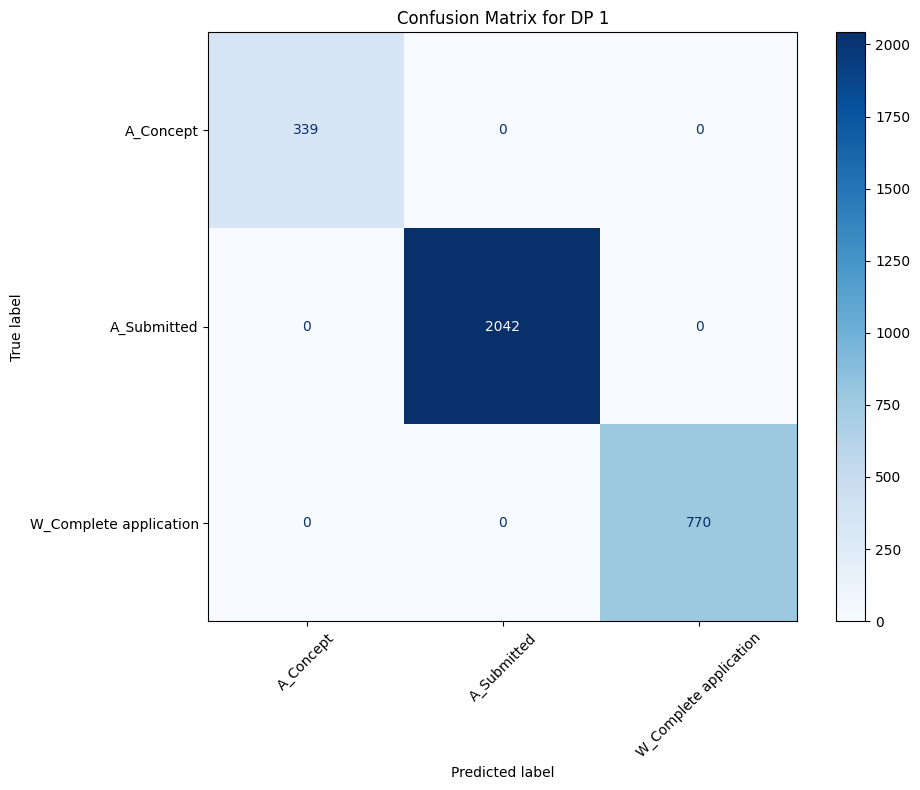

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Comparison for DP 3 (Holdout Set)
Weighted F1 (LSTM):     0.975
Weighted F1 (Baseline): 0.511
Relative Improvement:   90.65%


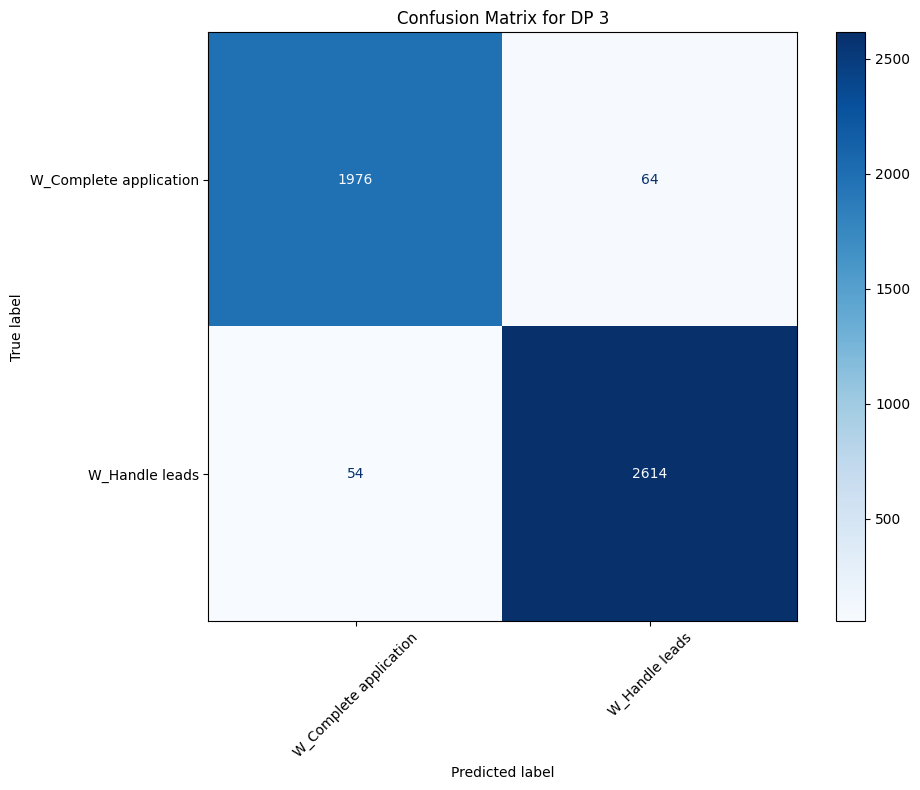

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 4 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.809
Relative Improvement:   23.57%


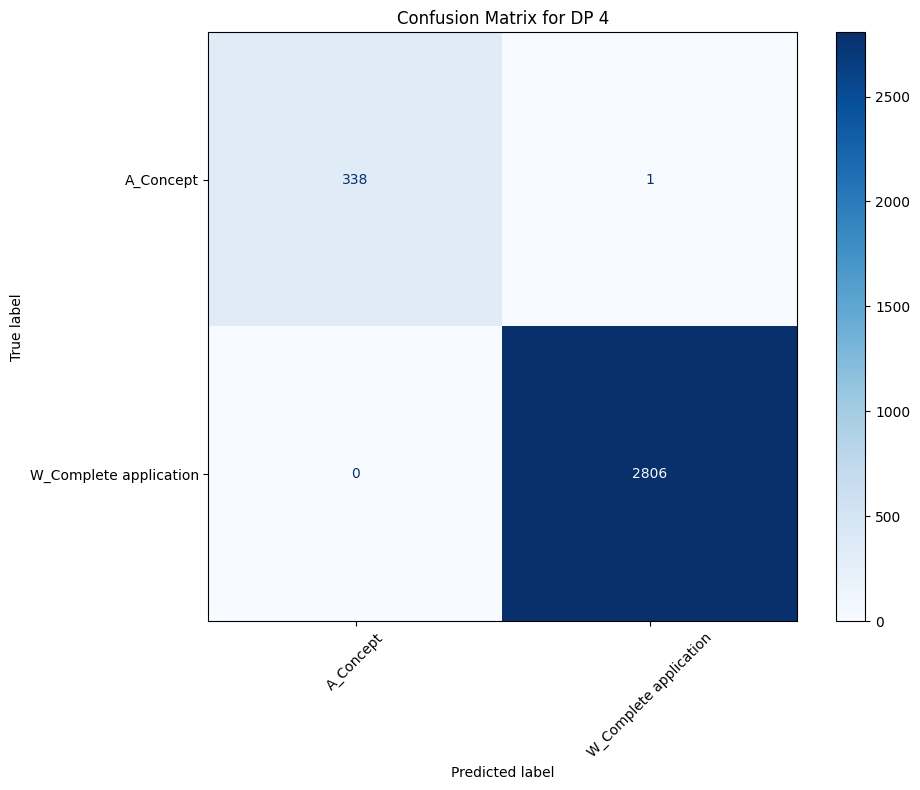

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 5 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.809
Relative Improvement:   23.61%


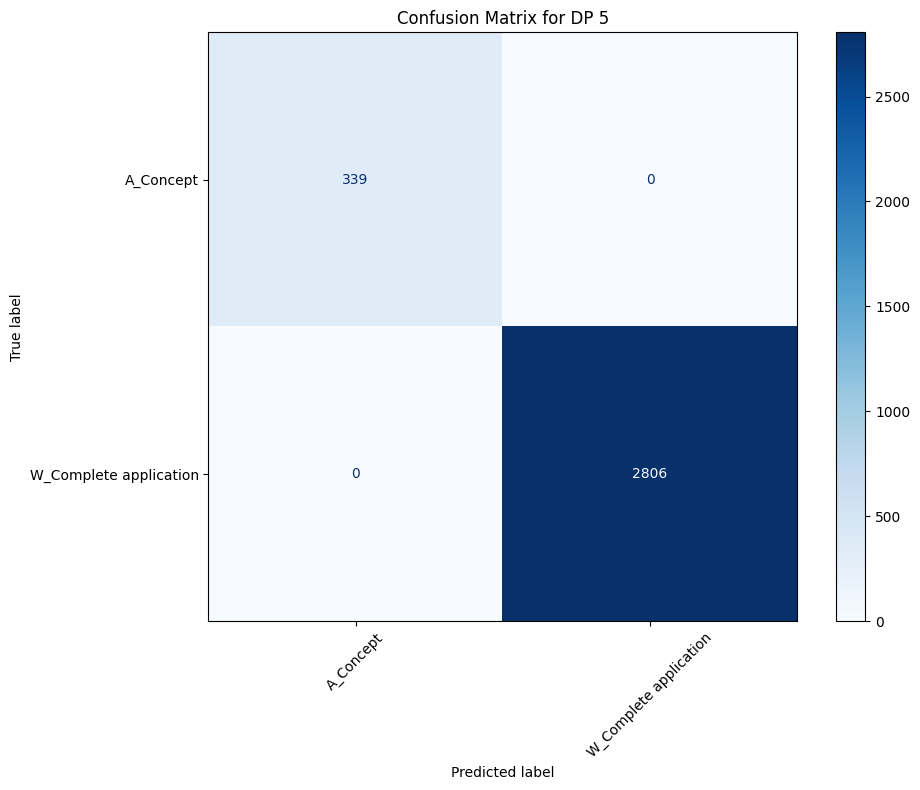

357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Comparison for DP 7 (Holdout Set)
Weighted F1 (LSTM):     0.788
Weighted F1 (Baseline): 0.394
Relative Improvement:   100.13%


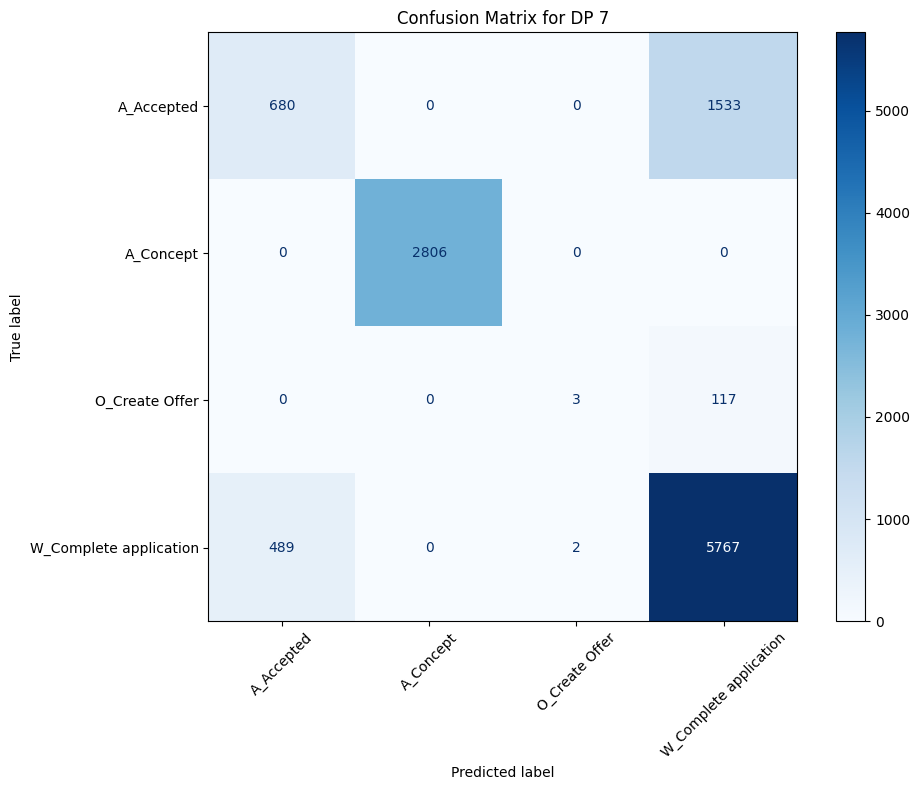

455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 8 (Holdout Set)
Weighted F1 (LSTM):     0.829
Weighted F1 (Baseline): 0.454
Relative Improvement:   82.49%


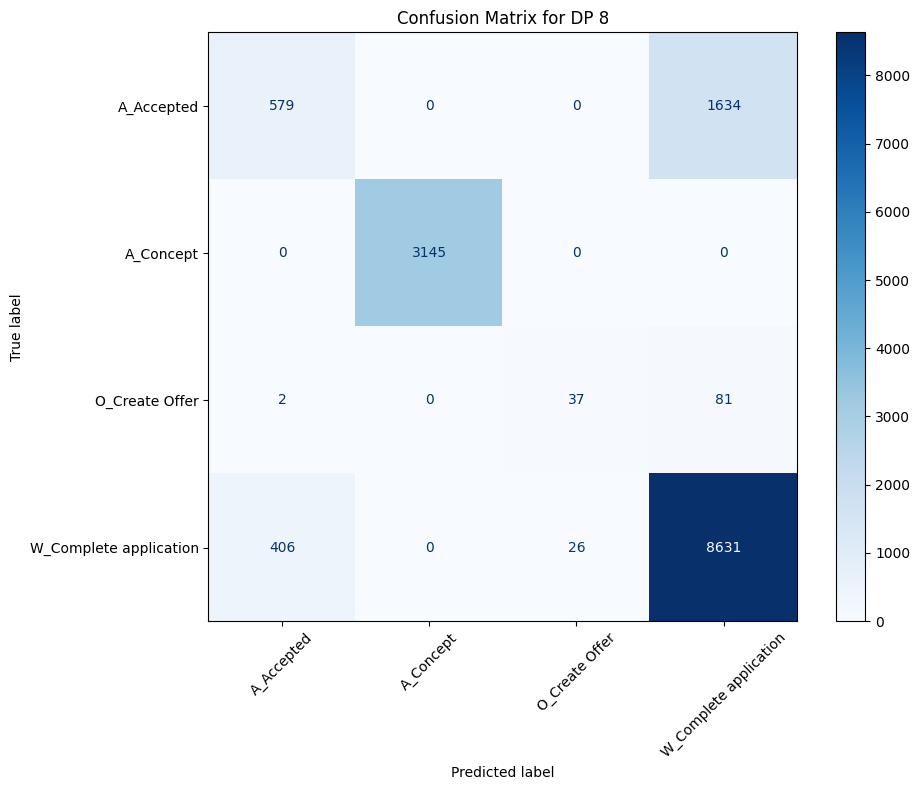

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 9 (Holdout Set)
Weighted F1 (LSTM):     0.848
Weighted F1 (Baseline): 0.494
Relative Improvement:   71.55%


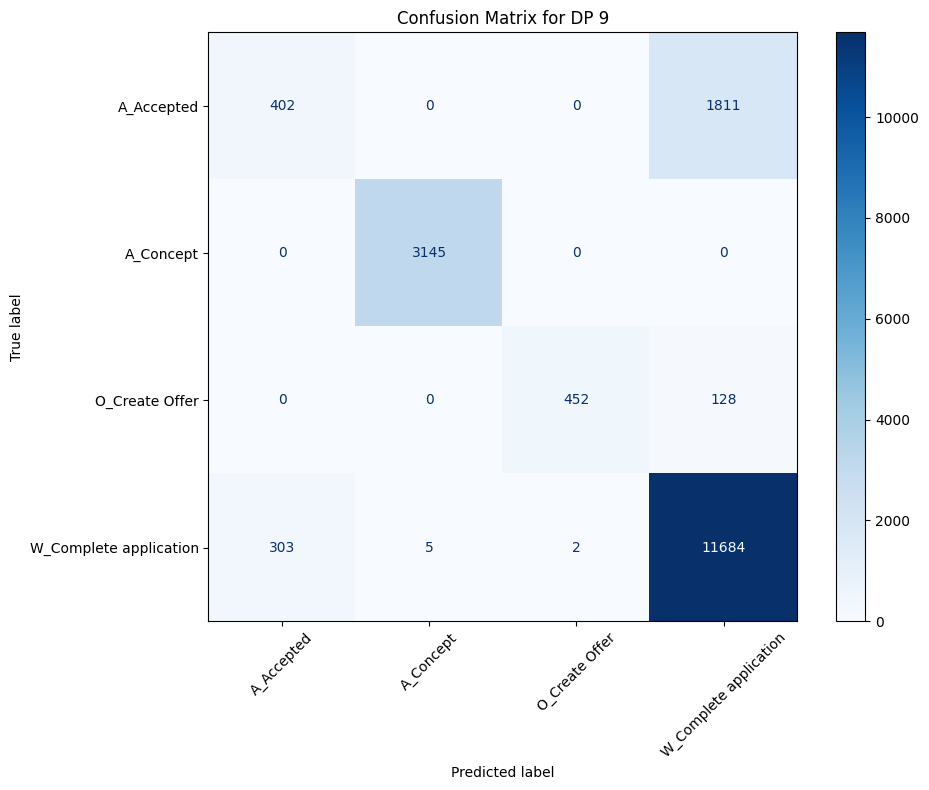

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 10 (Holdout Set)
Weighted F1 (LSTM):     0.865
Weighted F1 (Baseline): 0.494
Relative Improvement:   75.10%


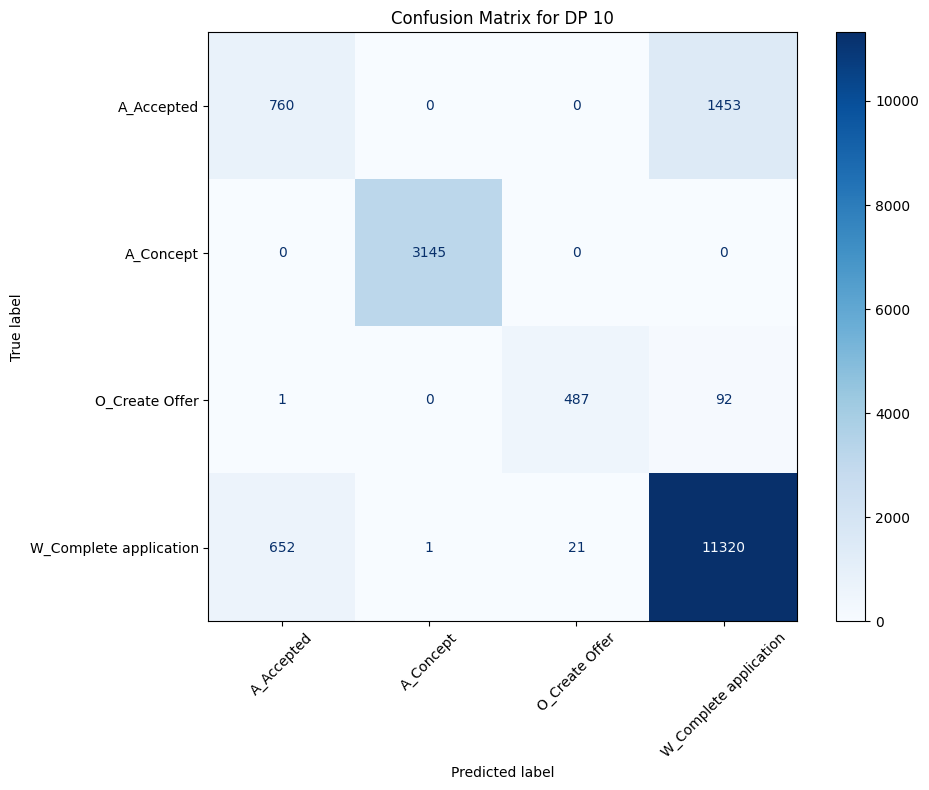

561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

Comparison for DP 11 (Holdout Set)
Weighted F1 (LSTM):     0.848
Weighted F1 (Baseline): 0.658
Relative Improvement:   28.93%


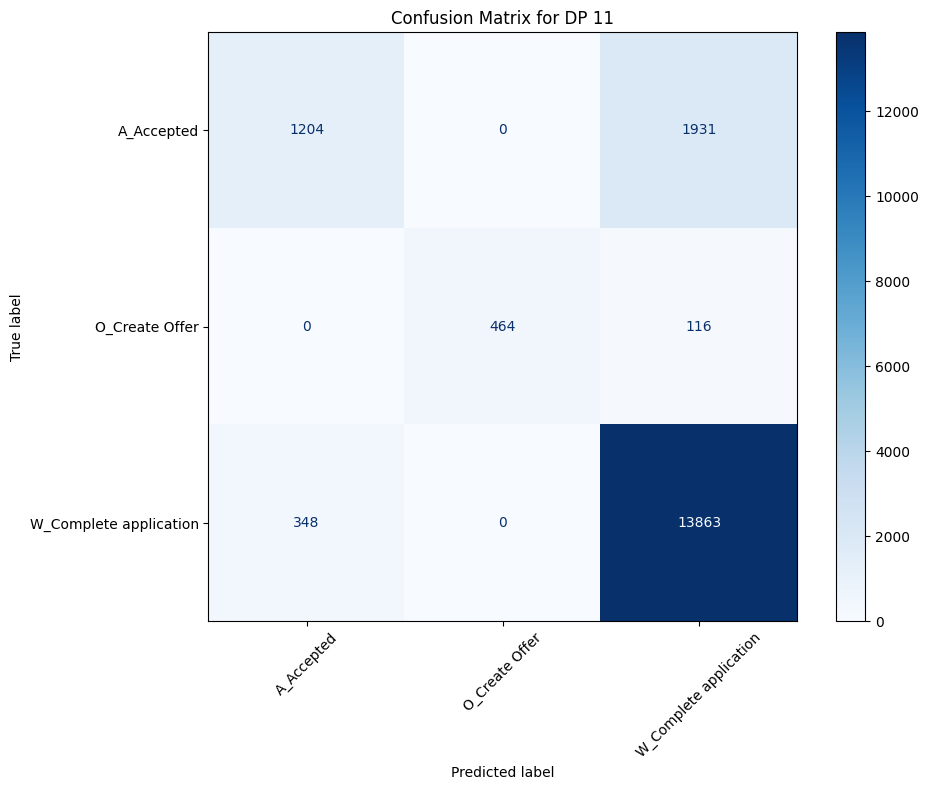

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 12 (Holdout Set)
Weighted F1 (LSTM):     0.850
Weighted F1 (Baseline): 0.658
Relative Improvement:   29.12%


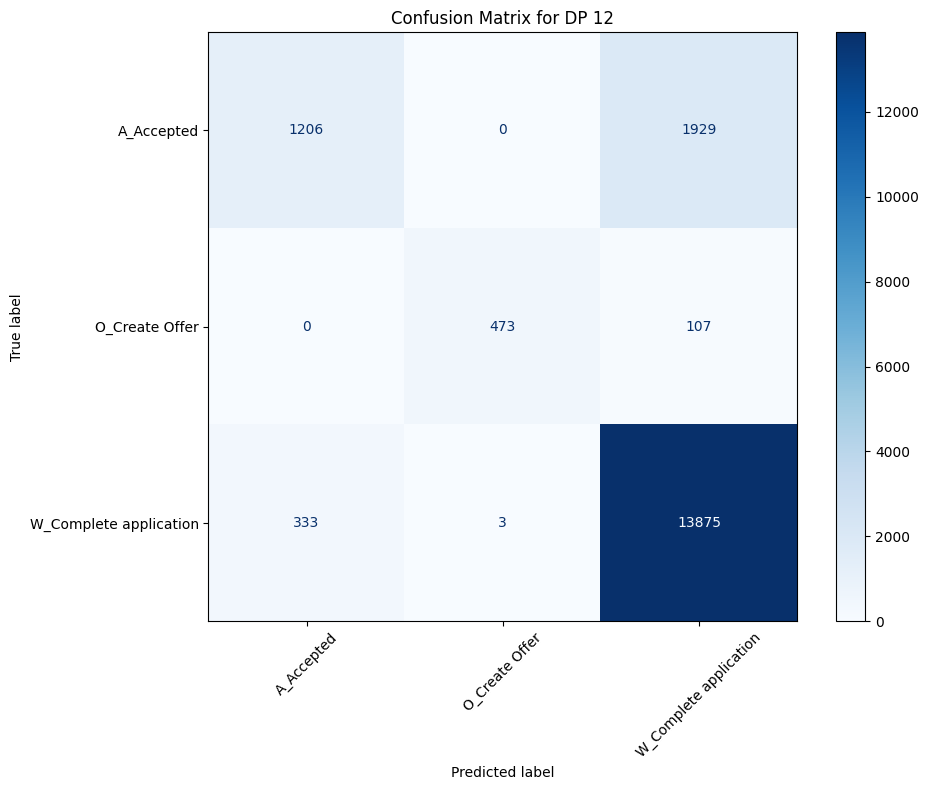

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 13 (Holdout Set)
Weighted F1 (LSTM):     0.987
Weighted F1 (Baseline): 0.688
Relative Improvement:   43.57%


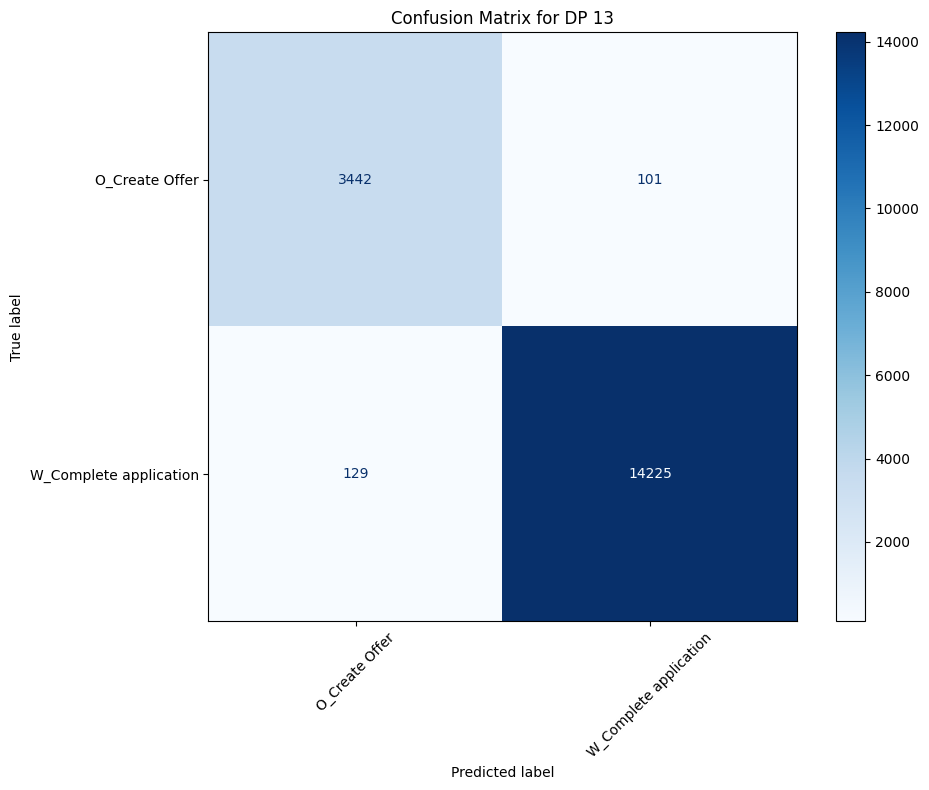

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 14 (Holdout Set)
Weighted F1 (LSTM):     0.965
Weighted F1 (Baseline): 0.930
Relative Improvement:   3.74%


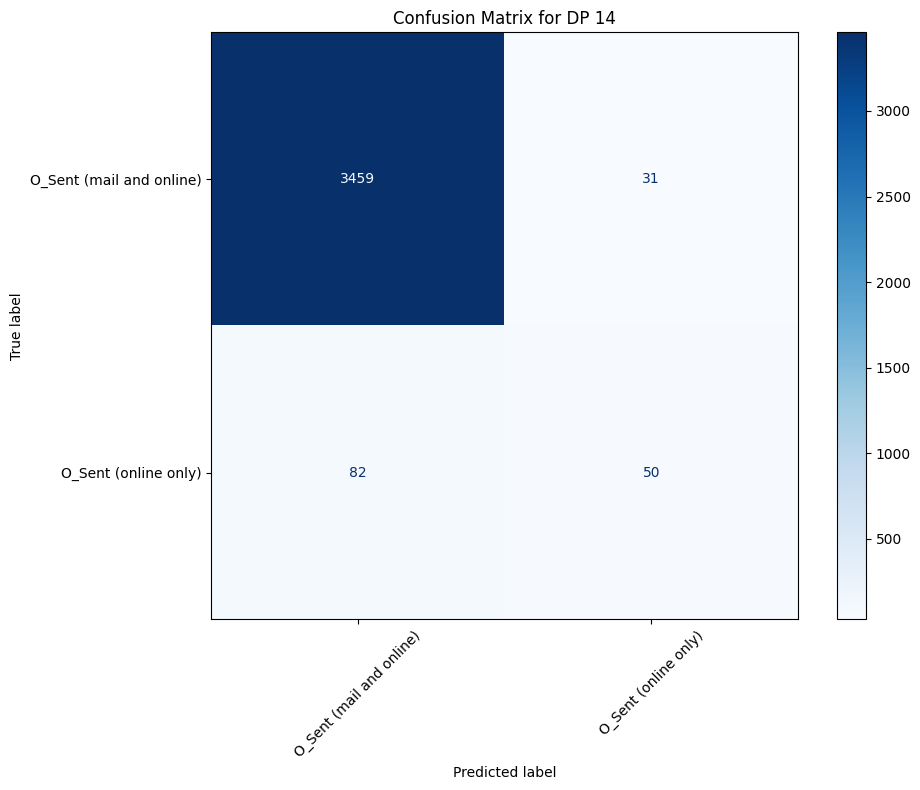

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 15 (Holdout Set)
Weighted F1 (LSTM):     0.968
Weighted F1 (Baseline): 0.930
Relative Improvement:   4.05%


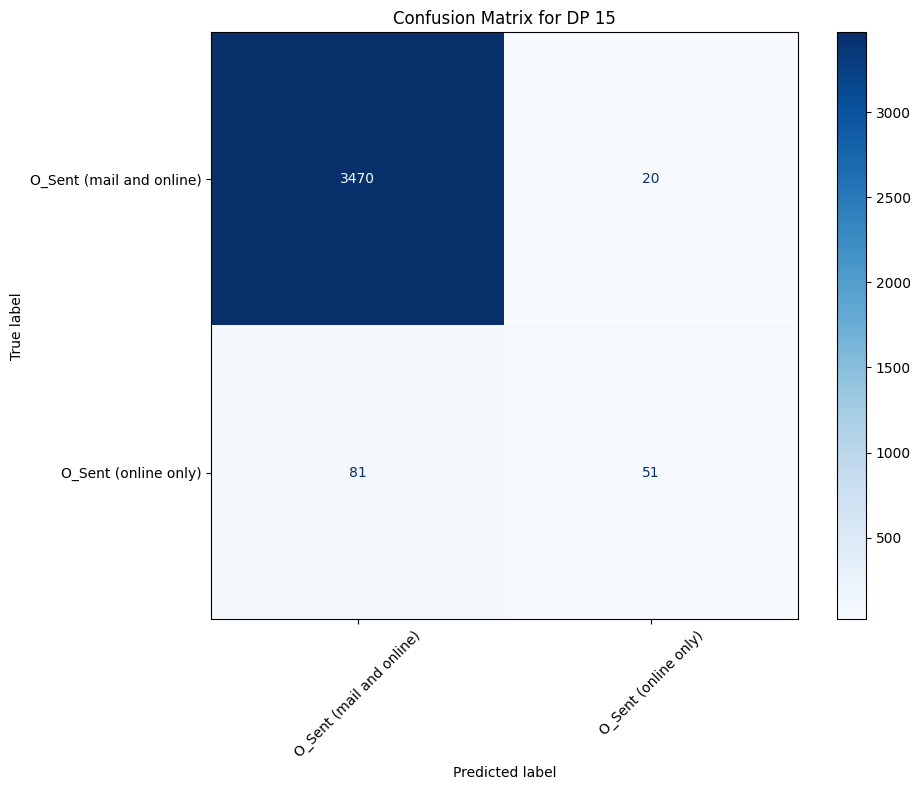

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 16 (Holdout Set)
Weighted F1 (LSTM):     0.985
Weighted F1 (Baseline): 0.796
Relative Improvement:   23.72%


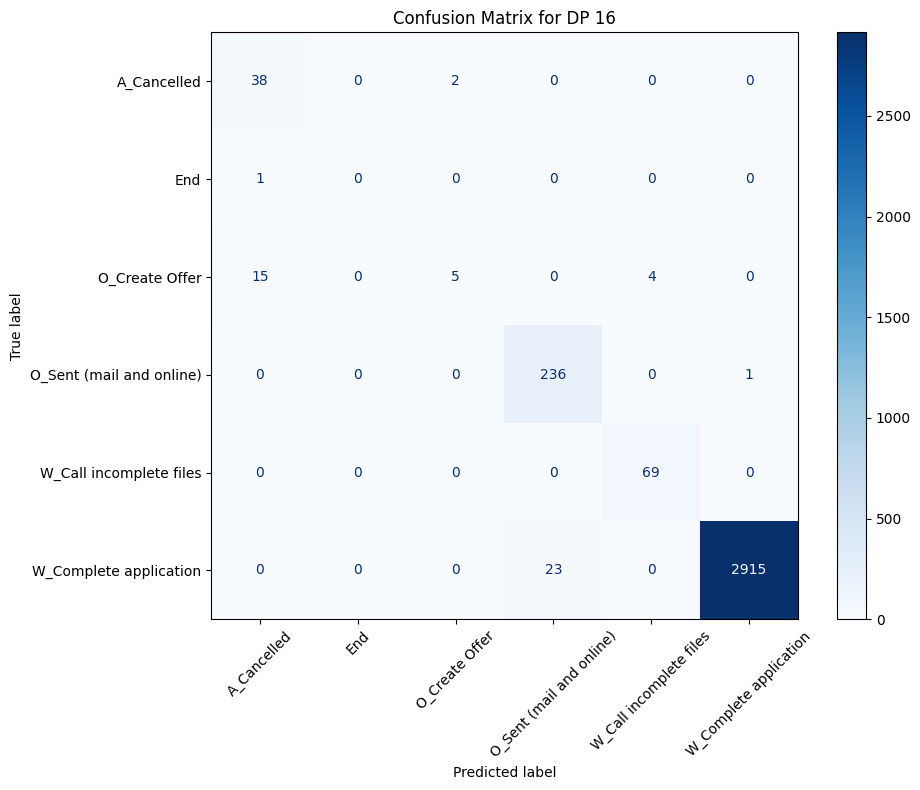

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 17 (Holdout Set)
Weighted F1 (LSTM):     0.985
Weighted F1 (Baseline): 0.796
Relative Improvement:   23.74%


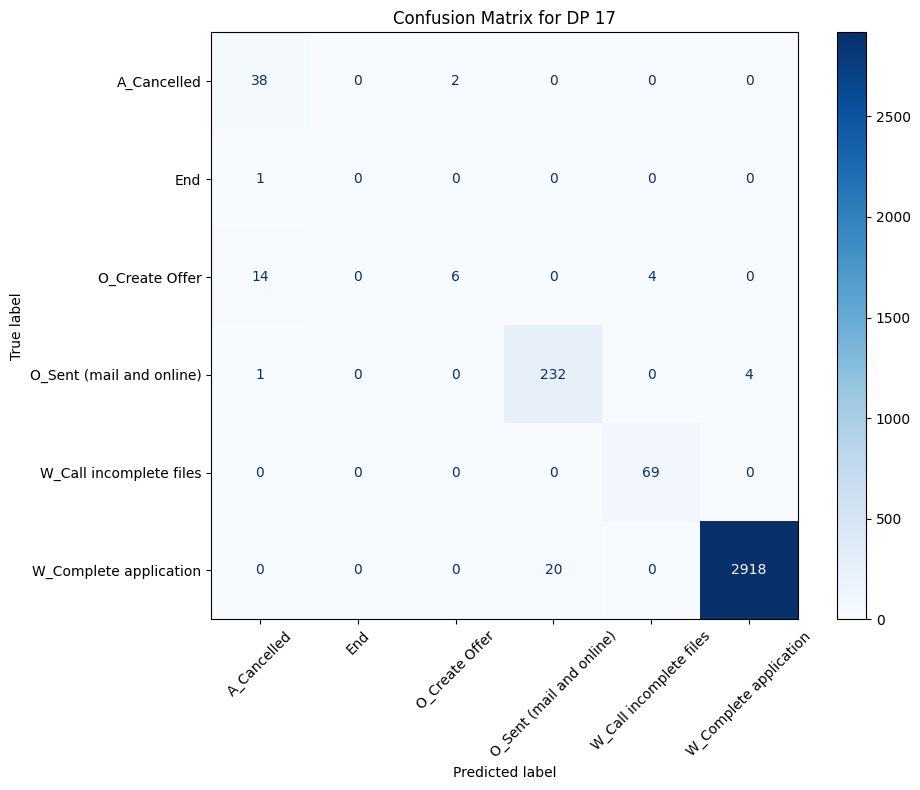

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 19 (Holdout Set)
Weighted F1 (LSTM):     0.883
Weighted F1 (Baseline): 0.414
Relative Improvement:   113.16%


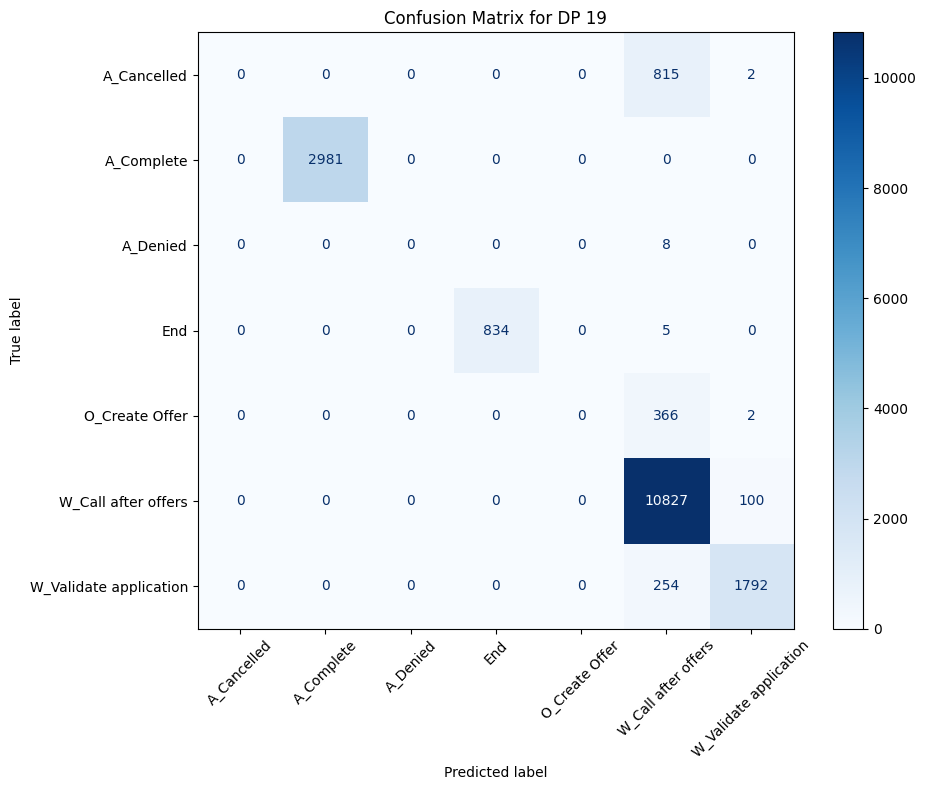

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Comparison for DP 20 (Holdout Set)
Weighted F1 (LSTM):     0.884
Weighted F1 (Baseline): 0.414
Relative Improvement:   113.42%


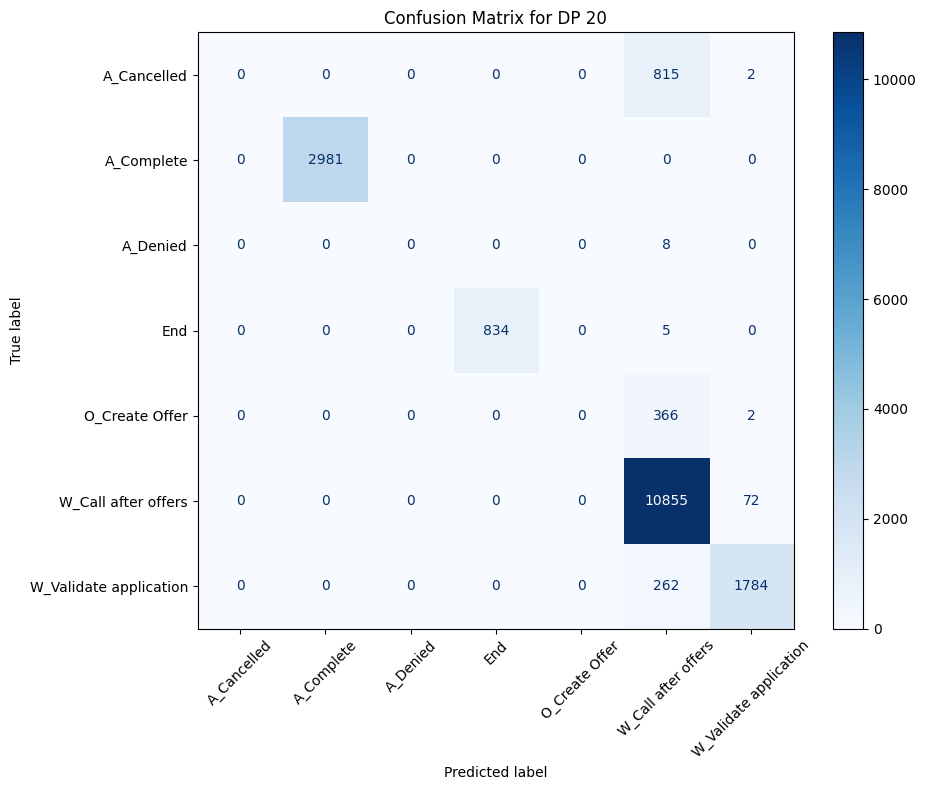

562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 21 (Holdout Set)
Weighted F1 (LSTM):     0.878
Weighted F1 (Baseline): 0.607
Relative Improvement:   44.54%


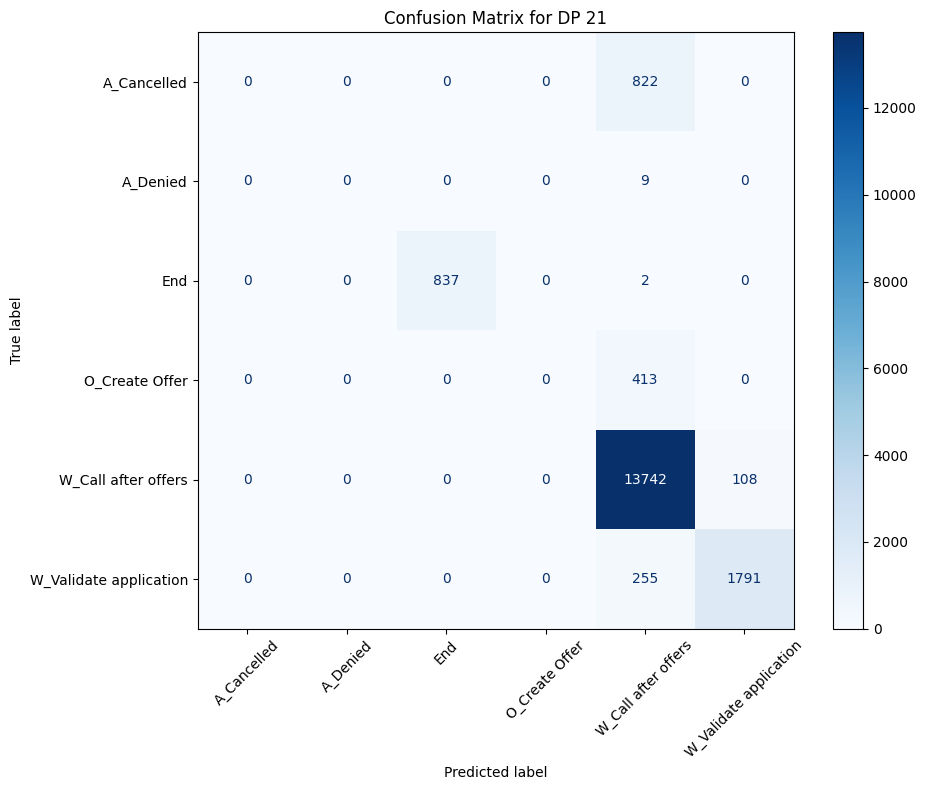

562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Comparison for DP 22 (Holdout Set)
Weighted F1 (LSTM):     0.880
Weighted F1 (Baseline): 0.607
Relative Improvement:   45.00%


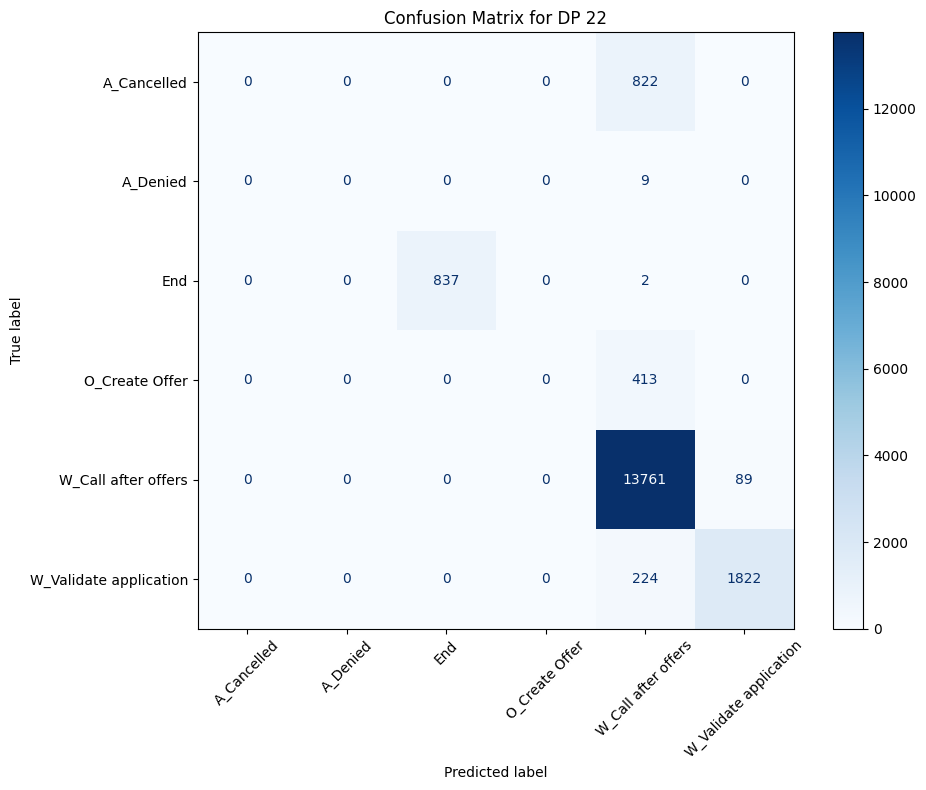

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 23 (Holdout Set)
Weighted F1 (LSTM):     0.951
Weighted F1 (Baseline): 0.278
Relative Improvement:   242.27%


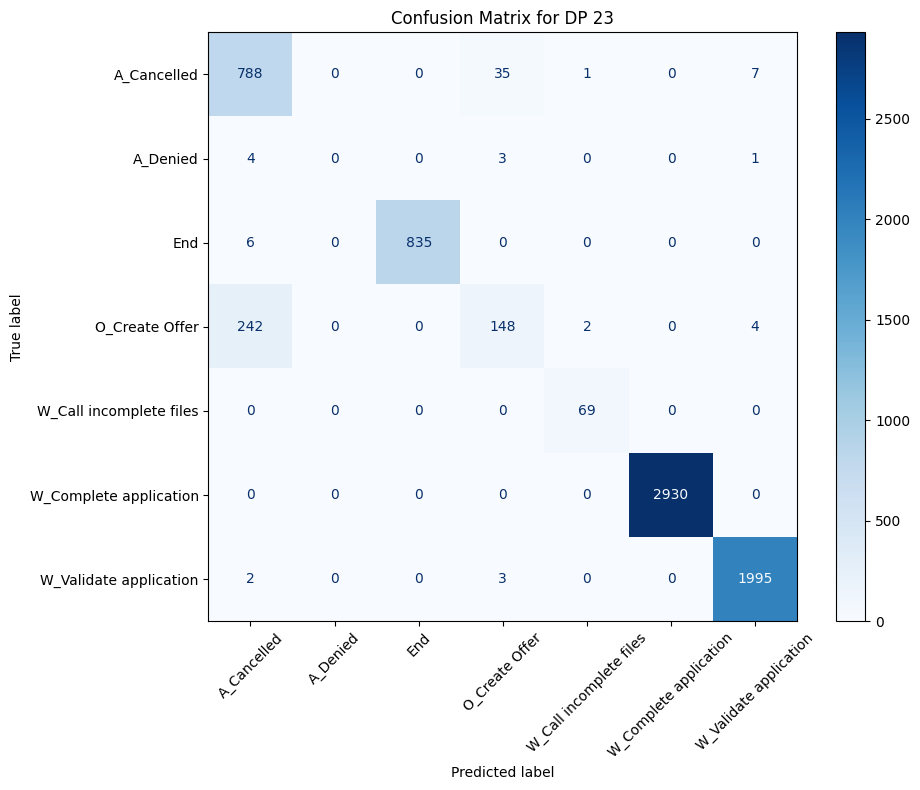

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Comparison for DP 25 (Holdout Set)
Weighted F1 (LSTM):     0.819
Weighted F1 (Baseline): 0.438
Relative Improvement:   87.14%


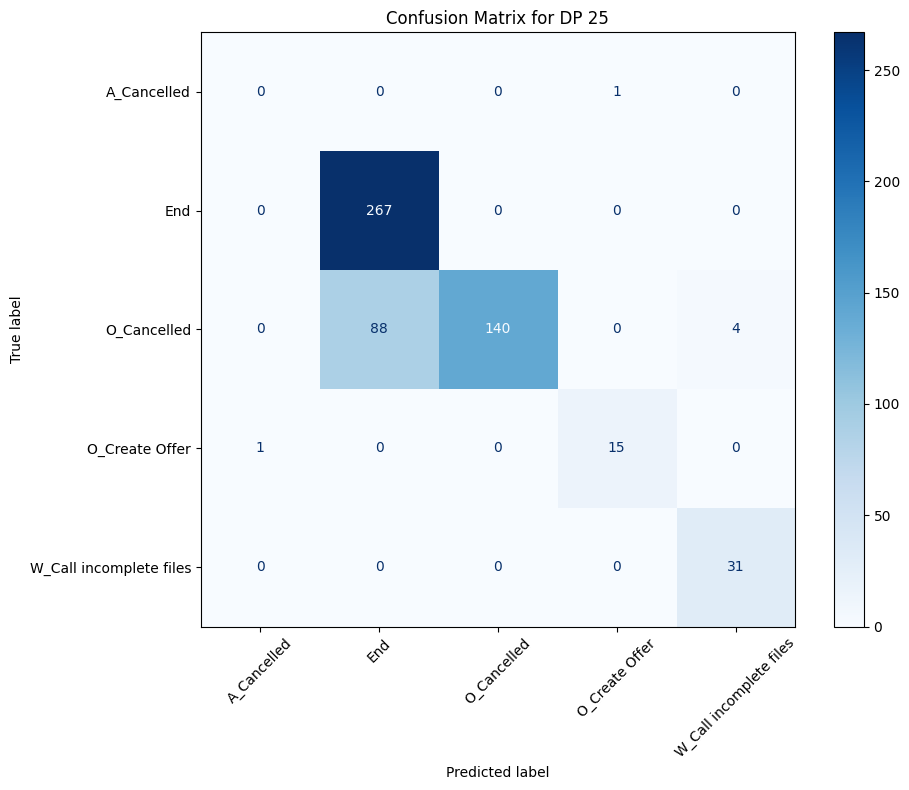

231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 26 (Holdout Set)
Weighted F1 (LSTM):     0.957
Weighted F1 (Baseline): 0.270
Relative Improvement:   253.97%


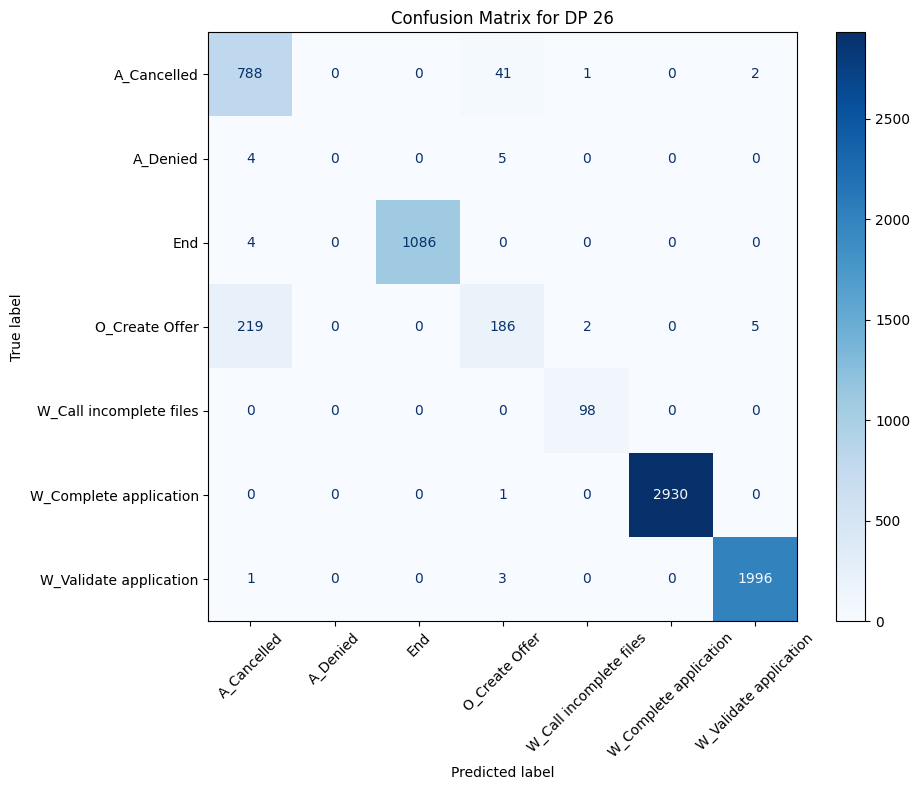

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 27 (Holdout Set)
Weighted F1 (LSTM):     0.862
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.74%


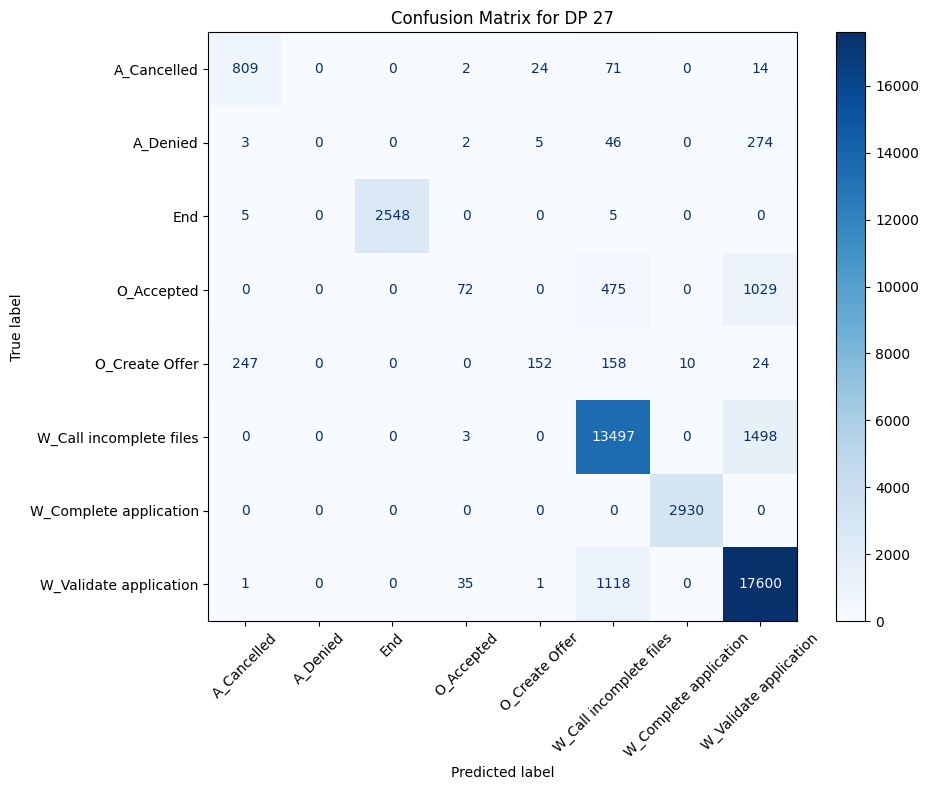

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 28 (Holdout Set)
Weighted F1 (LSTM):     0.857
Weighted F1 (Baseline): 0.329
Relative Improvement:   160.27%


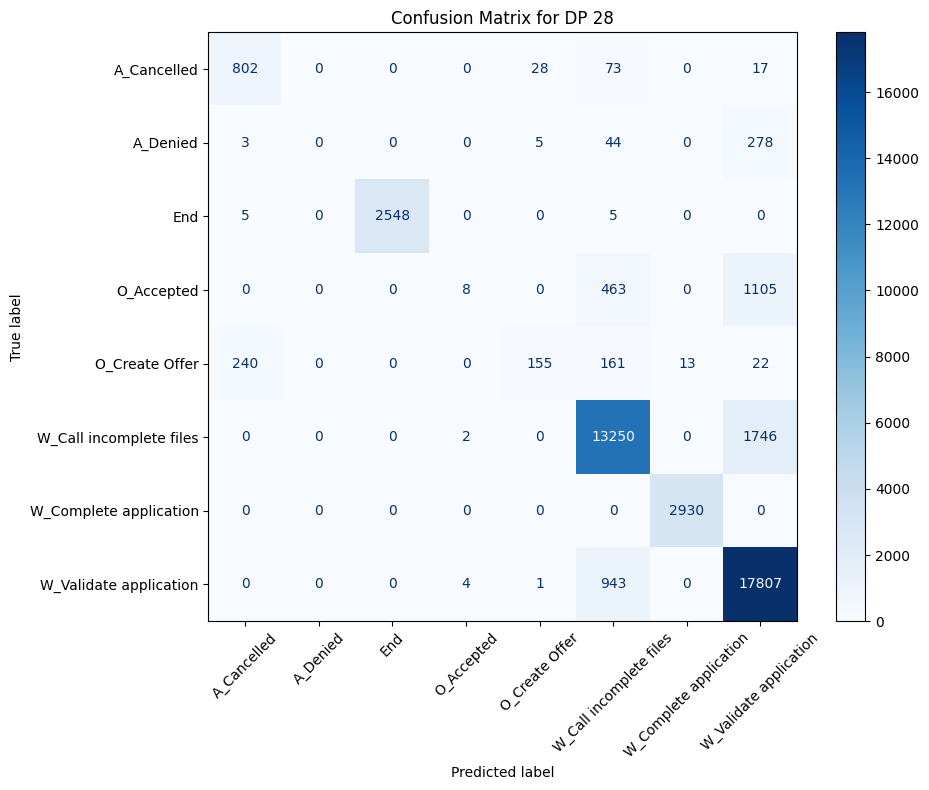

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 29 (Holdout Set)
Weighted F1 (LSTM):     0.863
Weighted F1 (Baseline): 0.329
Relative Improvement:   162.10%


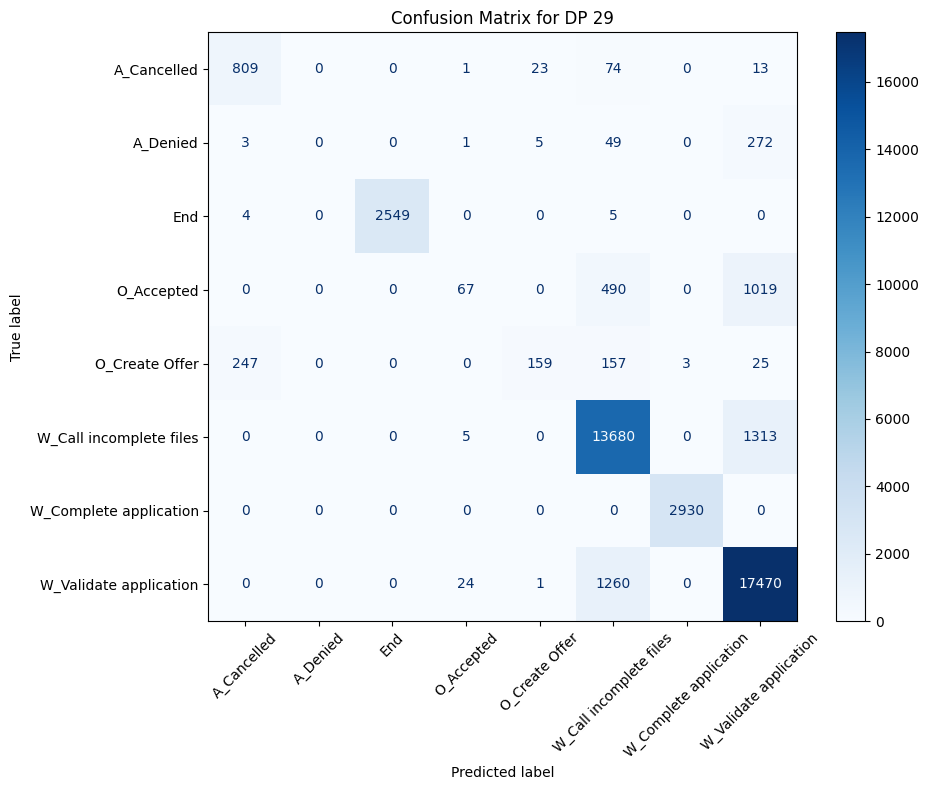

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 30 (Holdout Set)
Weighted F1 (LSTM):     0.863
Weighted F1 (Baseline): 0.329
Relative Improvement:   162.13%


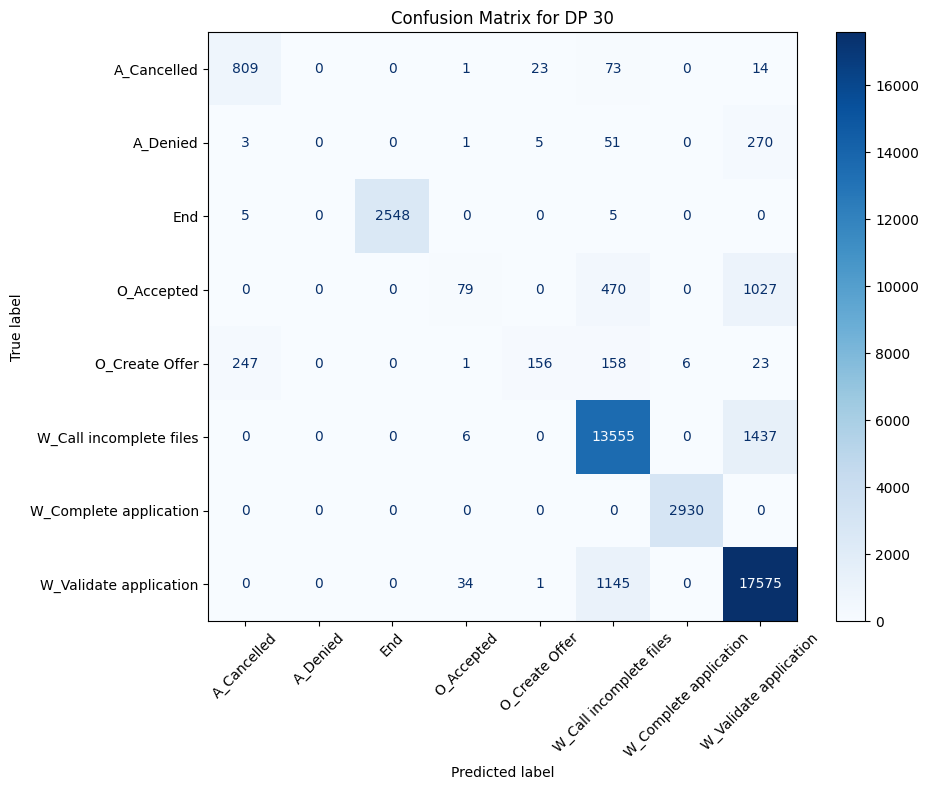

580/580 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

Comparison for DP 31 (Holdout Set)
Weighted F1 (LSTM):     0.794
Weighted F1 (Baseline): 0.372
Relative Improvement:   113.71%


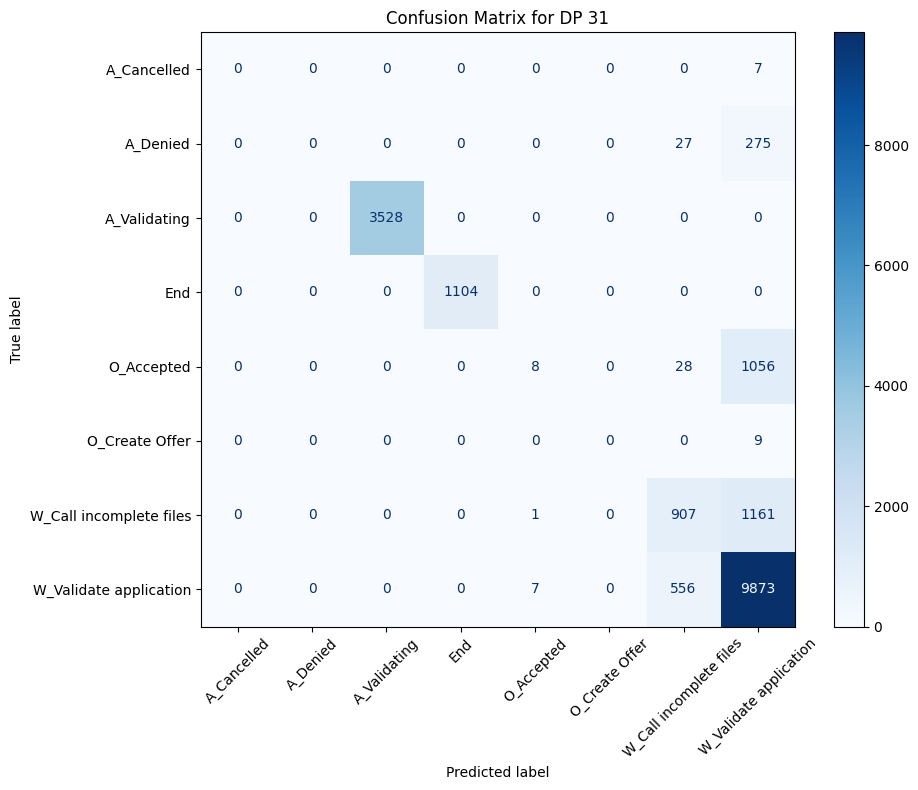

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step

Comparison for DP 32 (Holdout Set)
Weighted F1 (LSTM):     0.864
Weighted F1 (Baseline): 0.329
Relative Improvement:   162.24%


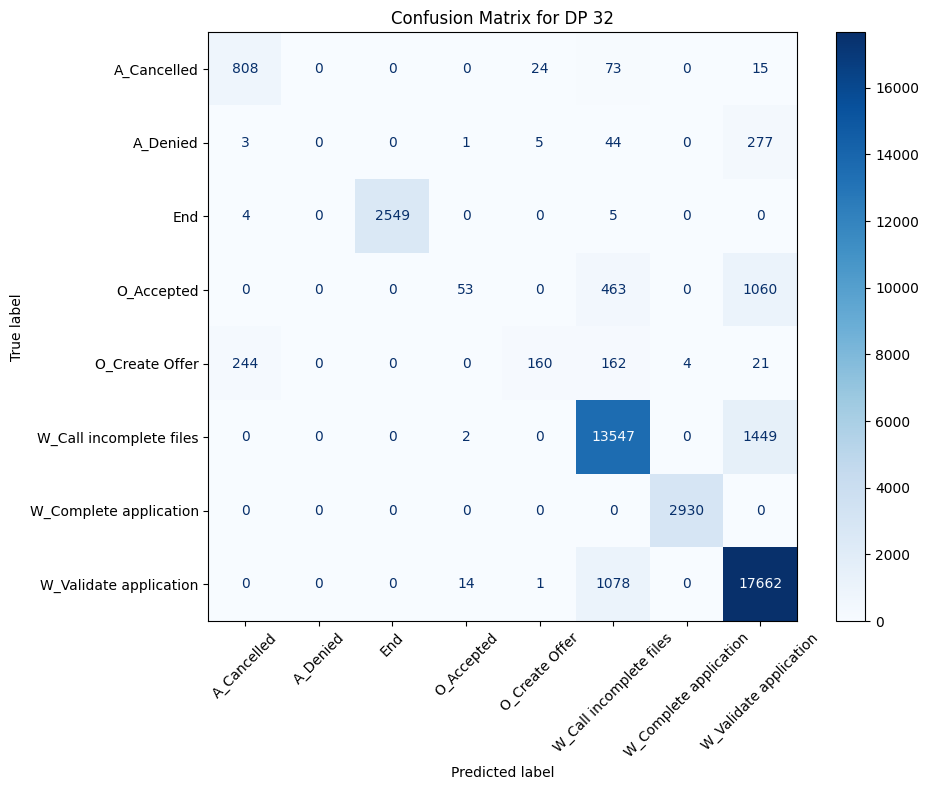

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Comparison for DP 33 (Holdout Set)
Weighted F1 (LSTM):     0.948
Weighted F1 (Baseline): 0.508
Relative Improvement:   86.53%


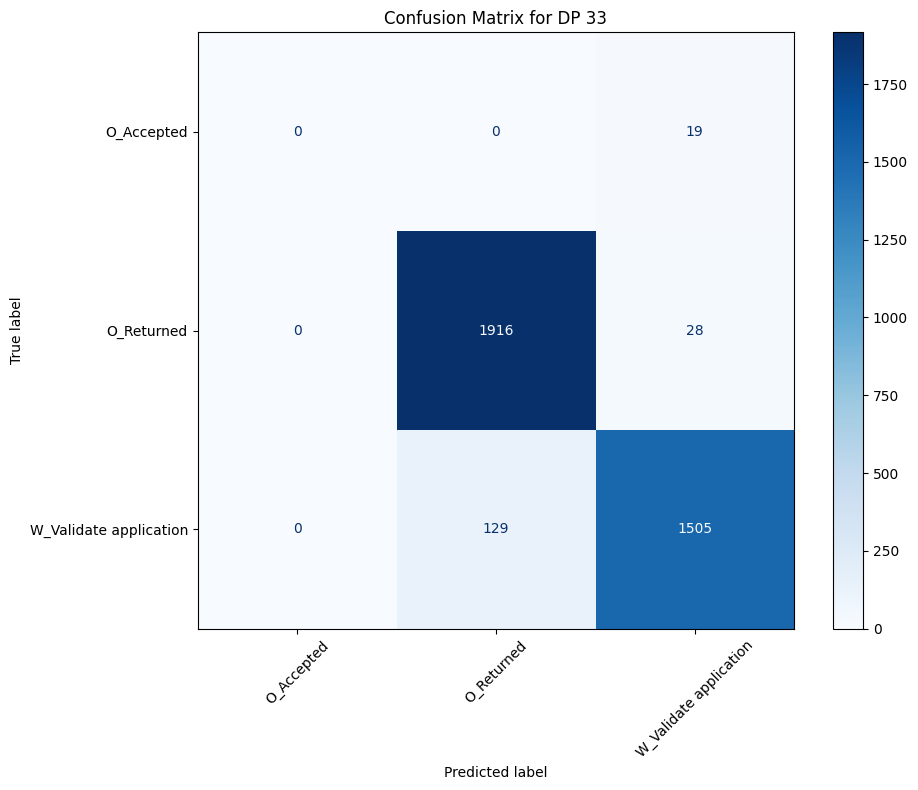

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Comparison for DP 34 (Holdout Set)
Weighted F1 (LSTM):     0.851
Weighted F1 (Baseline): 0.329
Relative Improvement:   158.37%


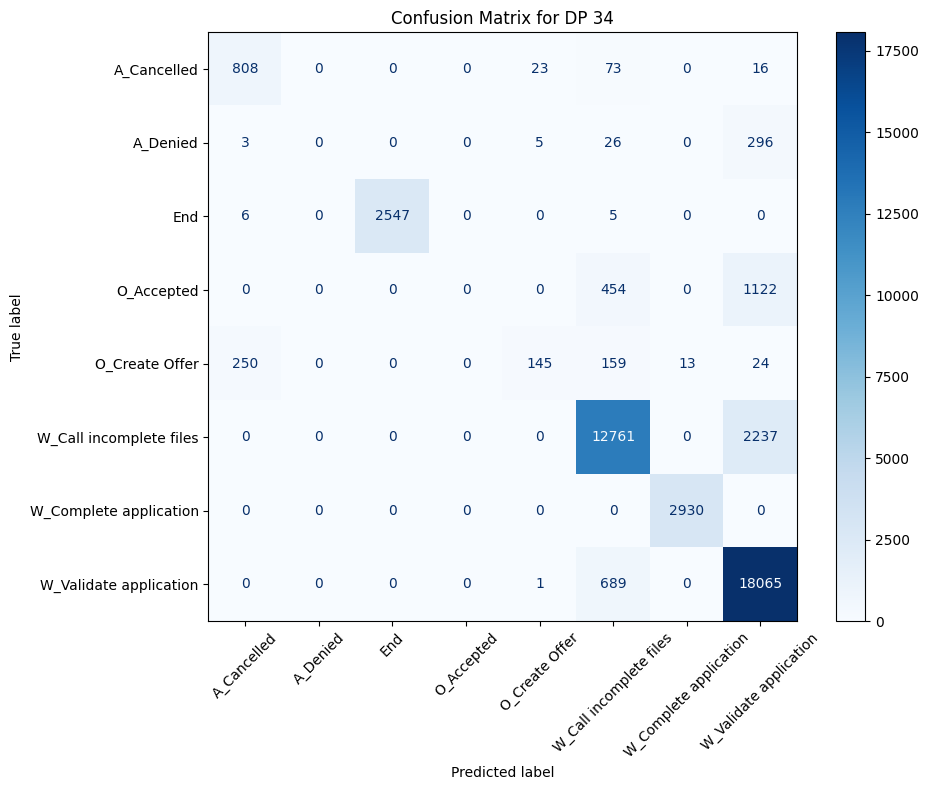

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 35 (Holdout Set)
Weighted F1 (LSTM):     0.864
Weighted F1 (Baseline): 0.329
Relative Improvement:   162.40%


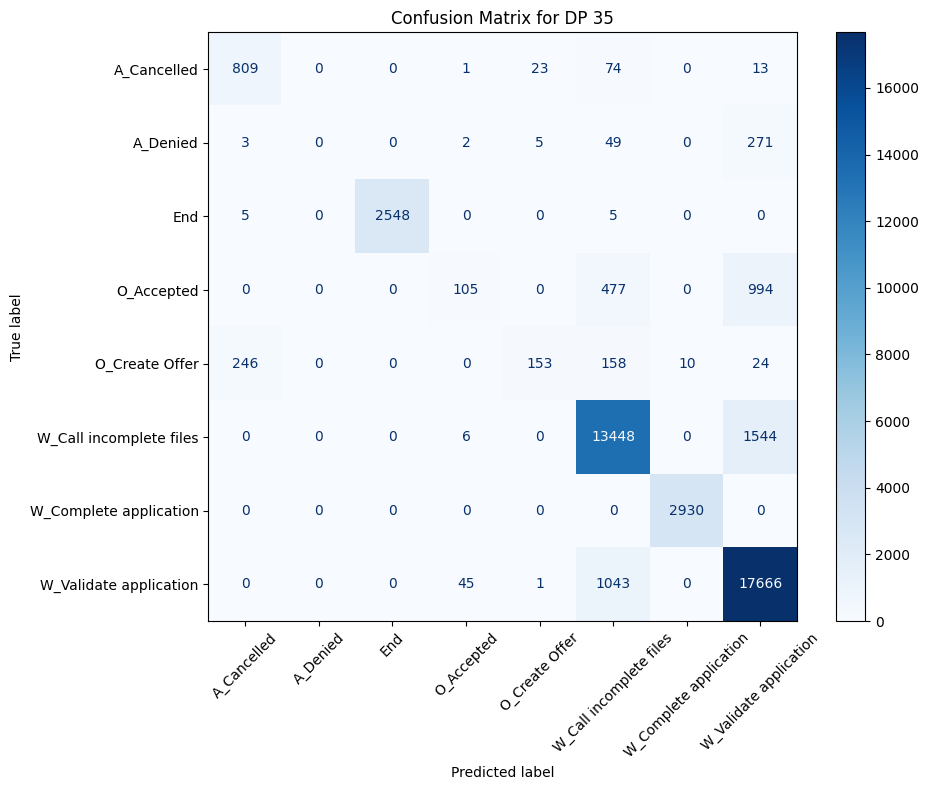

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 36 (Holdout Set)
Weighted F1 (LSTM):     0.852
Weighted F1 (Baseline): 0.329
Relative Improvement:   158.57%


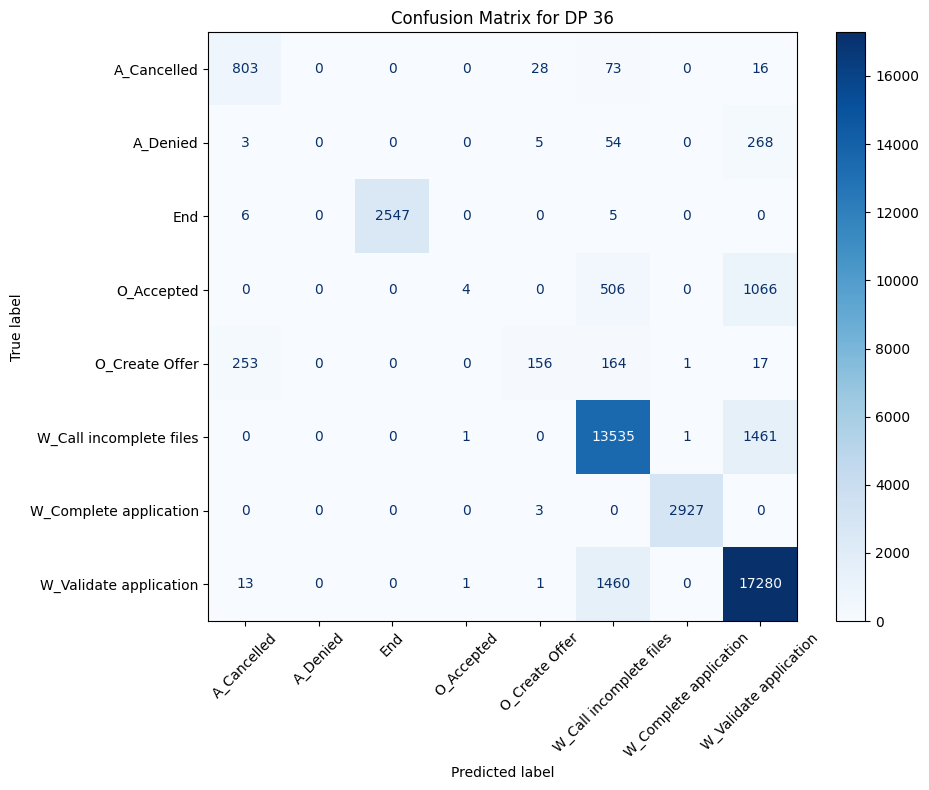

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step

Comparison for DP 37 (Holdout Set)
Weighted F1 (LSTM):     0.862
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.76%


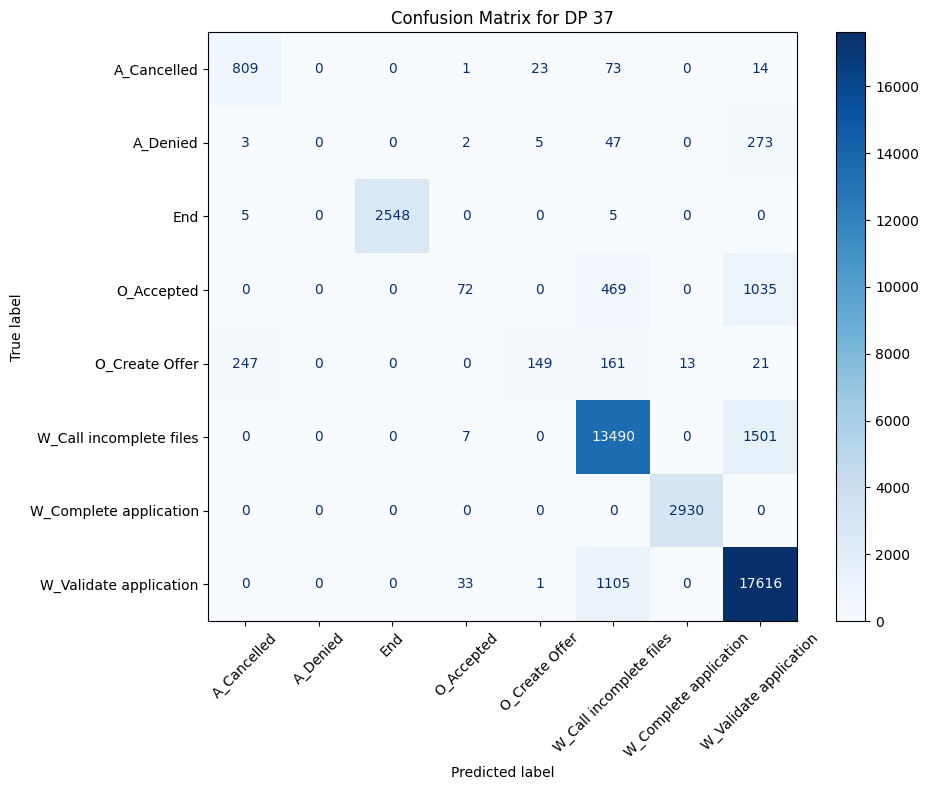

468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

Comparison for DP 39 (Holdout Set)
Weighted F1 (LSTM):     0.857
Weighted F1 (Baseline): 0.504
Relative Improvement:   70.16%


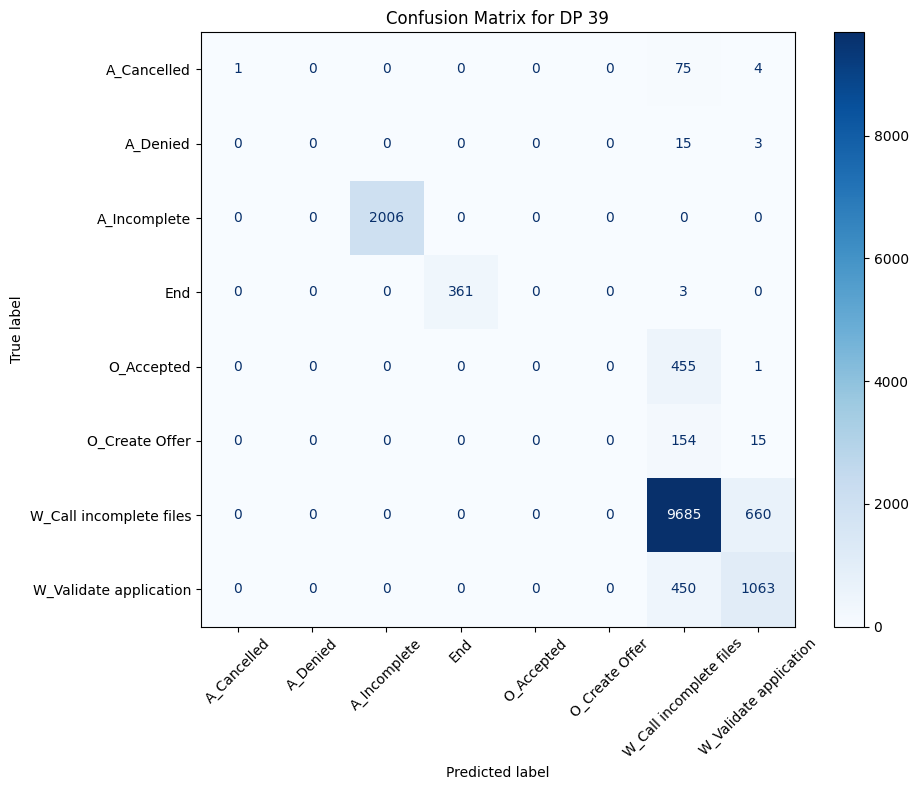

467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Comparison for DP 40 (Holdout Set)
Weighted F1 (LSTM):     0.854
Weighted F1 (Baseline): 0.693
Relative Improvement:   23.27%


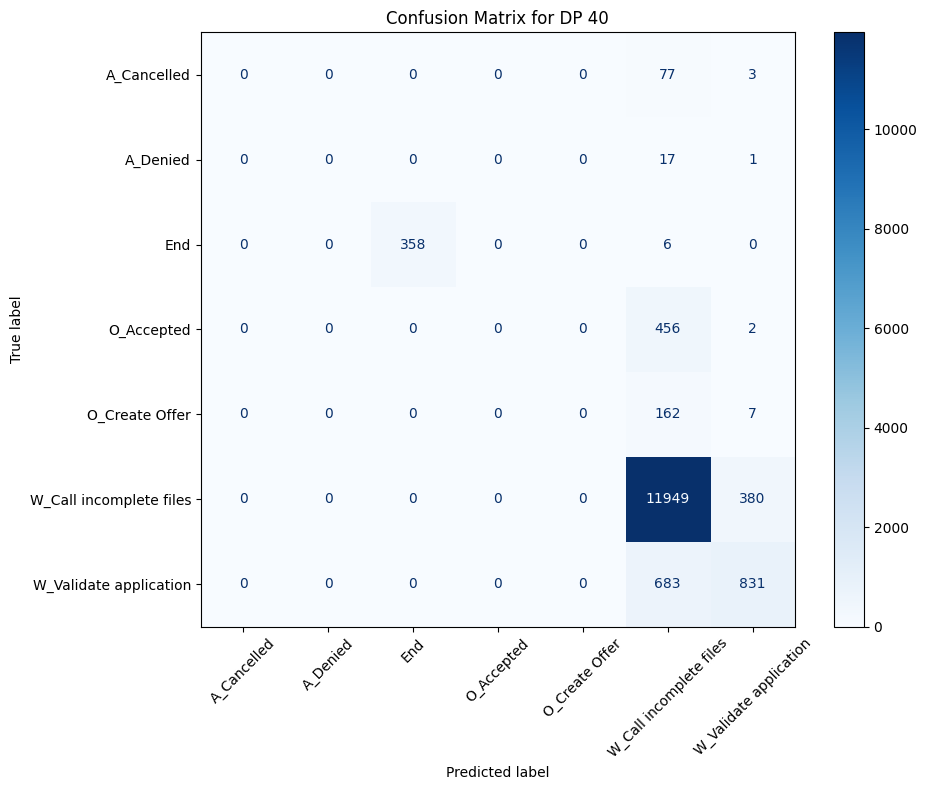

467/467 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

Comparison for DP 41 (Holdout Set)
Weighted F1 (LSTM):     0.858
Weighted F1 (Baseline): 0.693
Relative Improvement:   23.77%


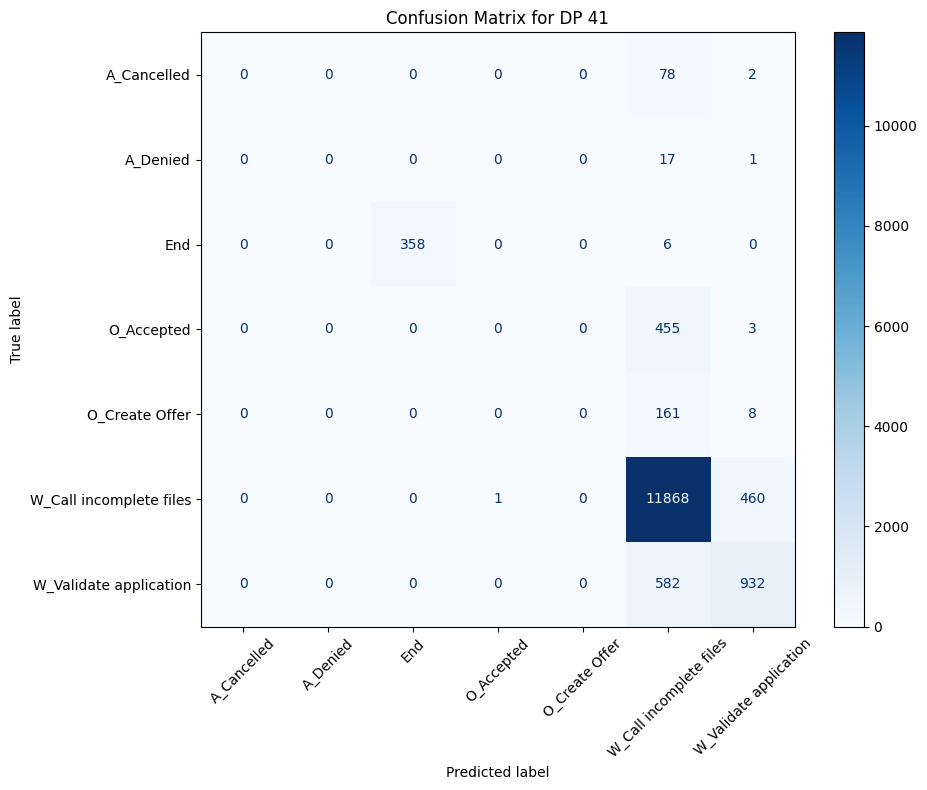

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step

Comparison for DP 42 (Holdout Set)
Weighted F1 (LSTM):     0.864
Weighted F1 (Baseline): 0.329
Relative Improvement:   162.46%


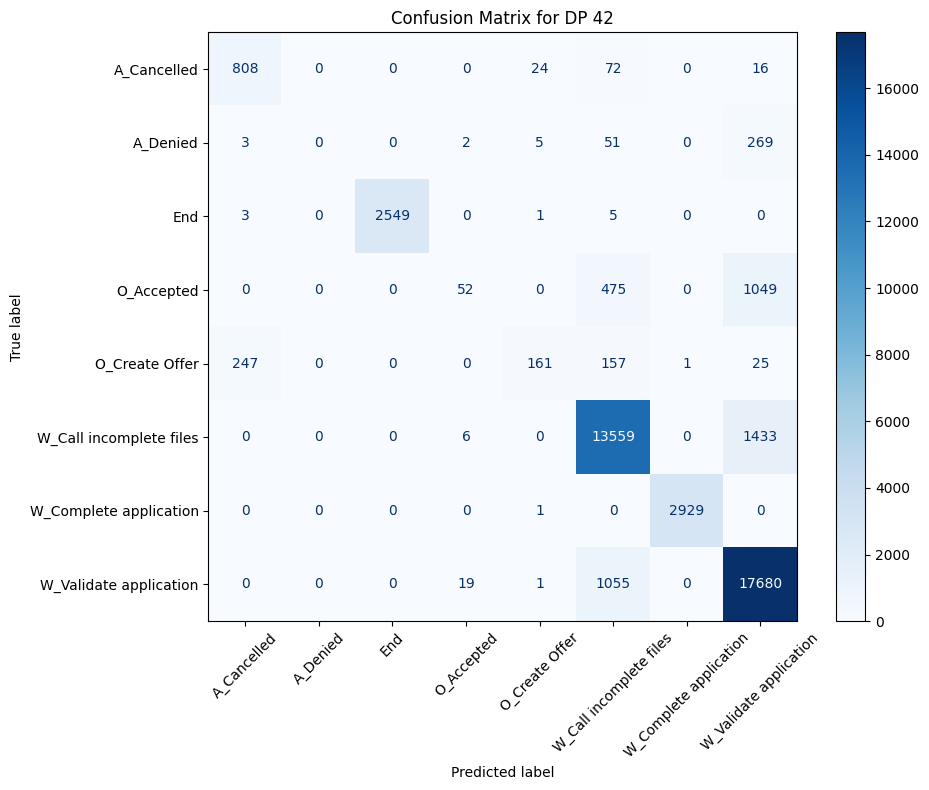

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

Comparison for DP 43 (Holdout Set)
Weighted F1 (LSTM):     0.862
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.59%


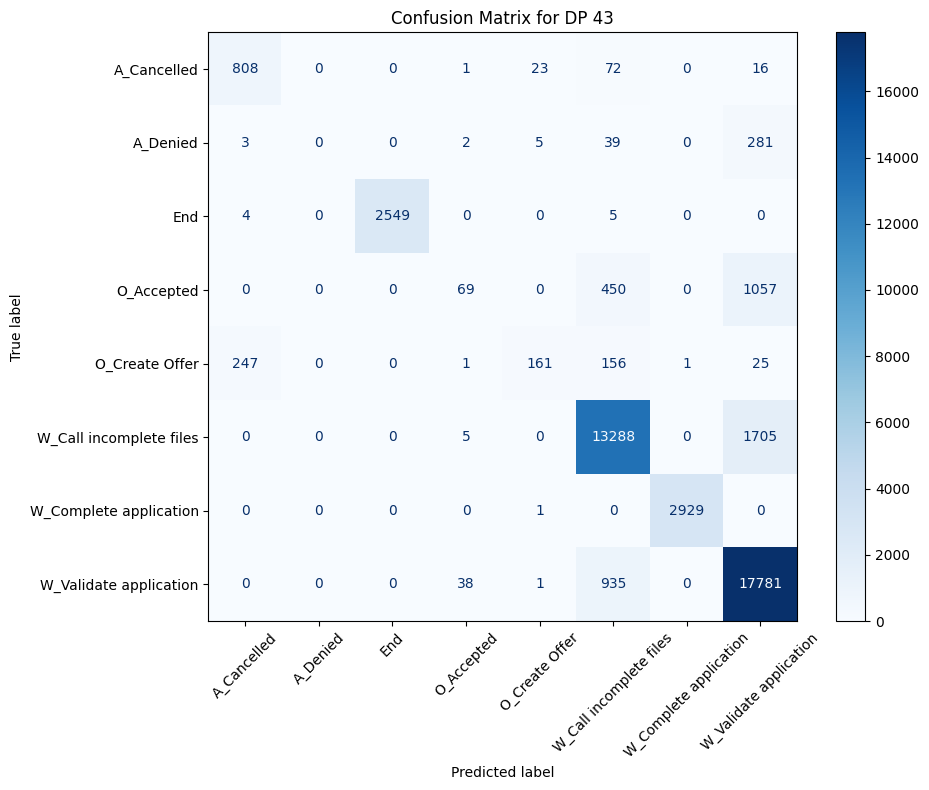

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Comparison for DP 44 (Holdout Set)
Weighted F1 (LSTM):     0.824
Weighted F1 (Baseline): 0.431
Relative Improvement:   91.11%


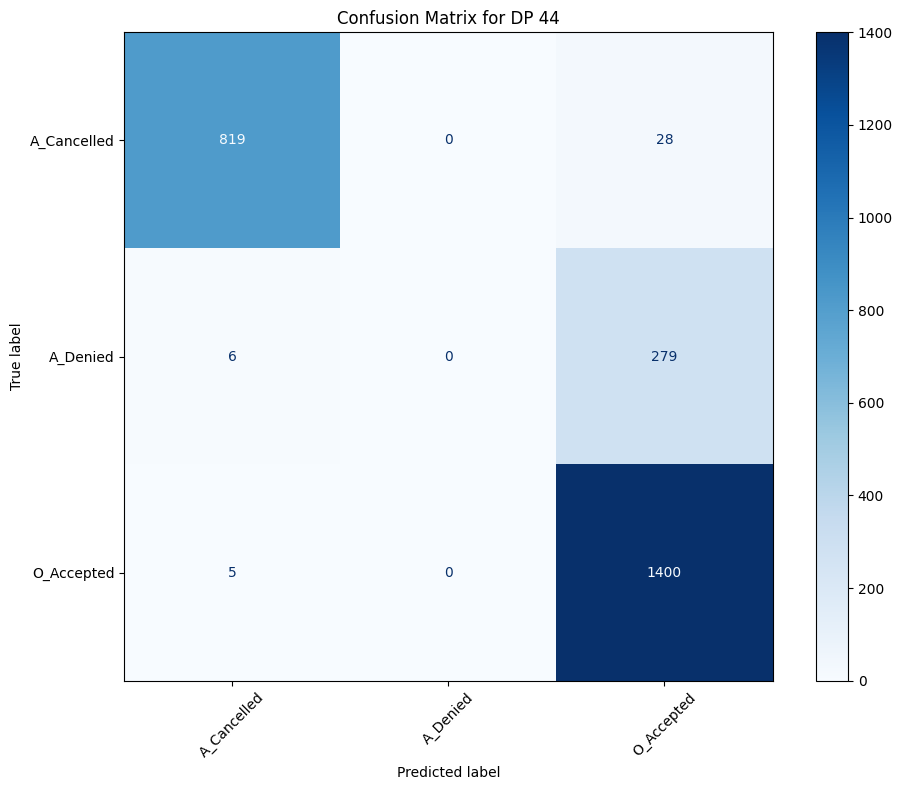

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Comparison for DP 46 (Holdout Set)
Weighted F1 (LSTM):     0.808
Weighted F1 (Baseline): 0.438
Relative Improvement:   84.59%


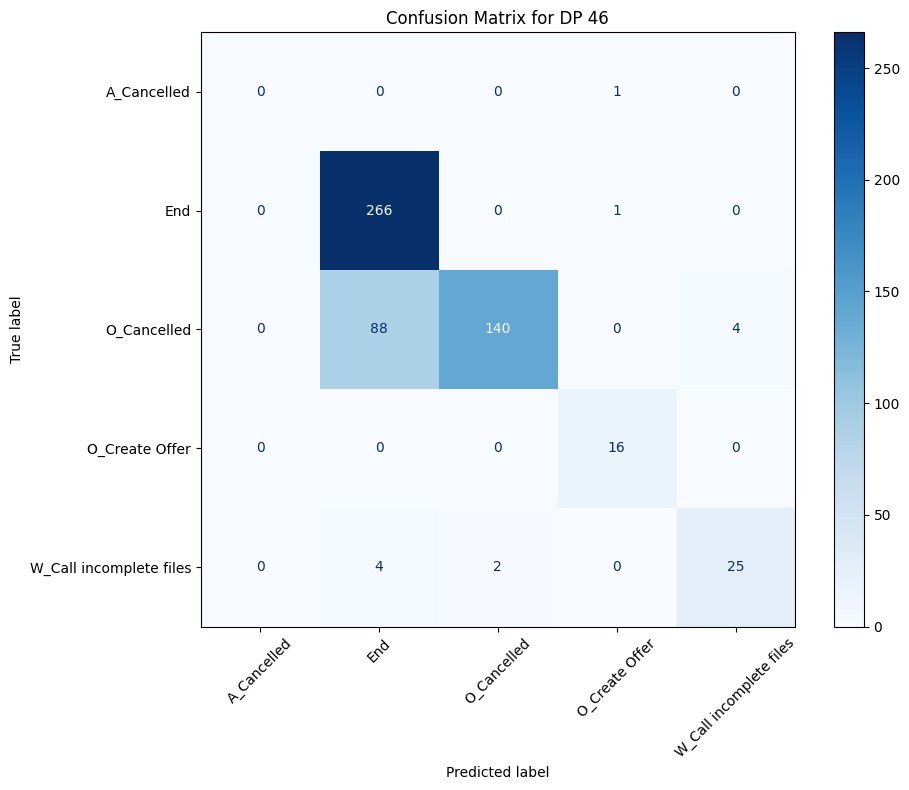

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Comparison for DP 47 (Holdout Set)
Weighted F1 (LSTM):     0.999
Weighted F1 (Baseline): 0.476
Relative Improvement:   110.01%


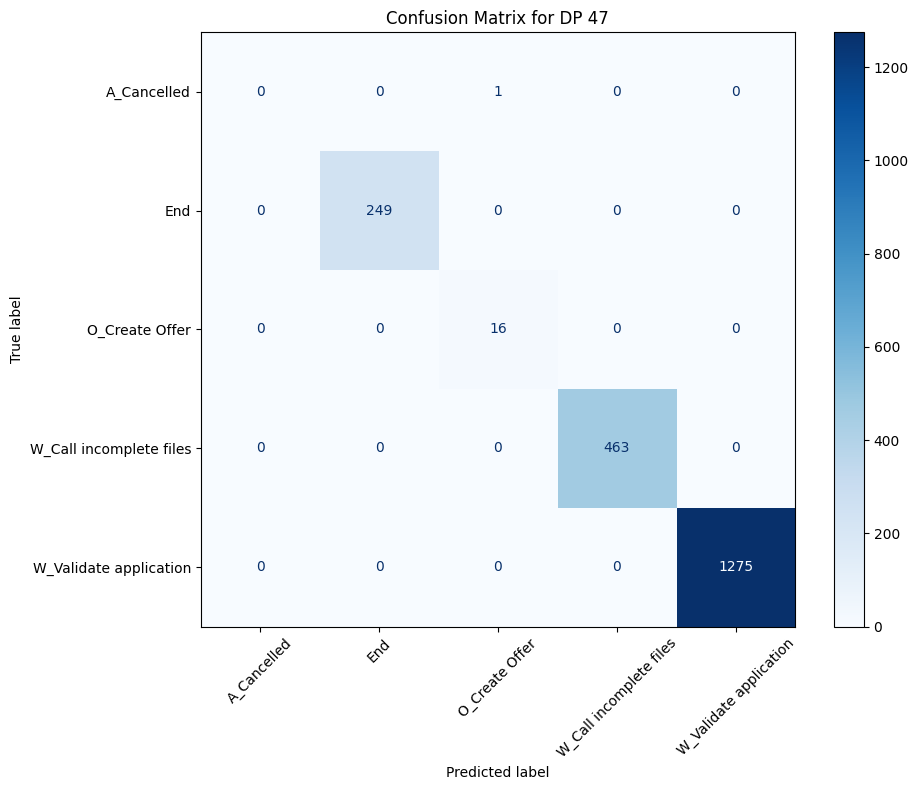

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step

Comparison for DP 48 (Holdout Set)
Weighted F1 (LSTM):     0.854
Weighted F1 (Baseline): 0.329
Relative Improvement:   159.32%


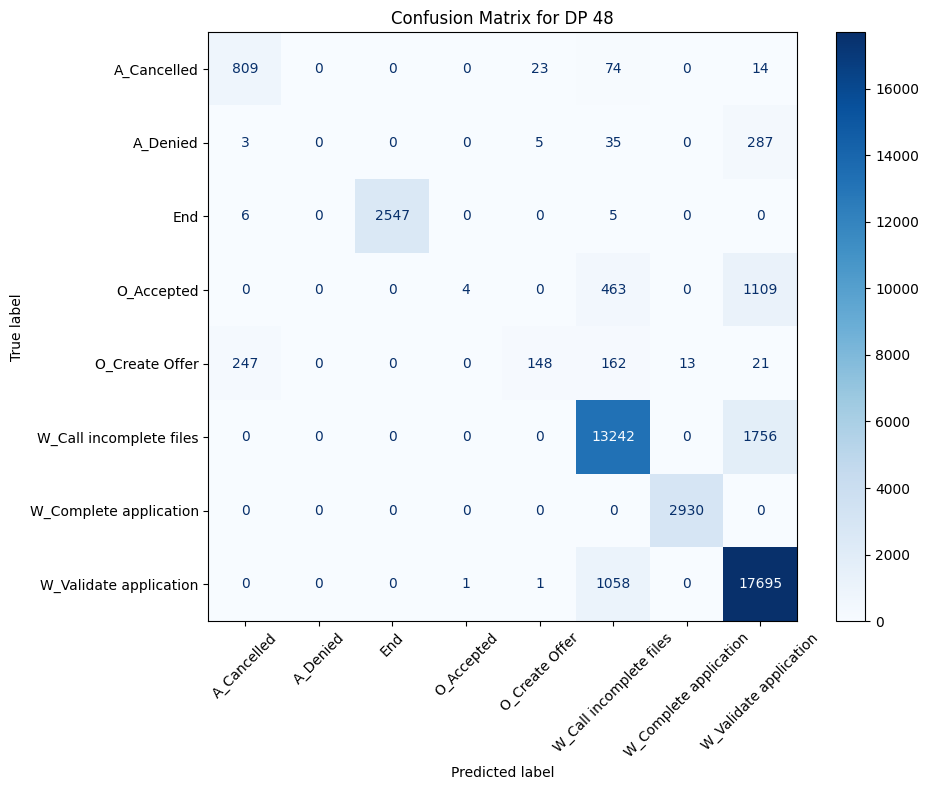

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

Comparison for DP 49 (Holdout Set)
Weighted F1 (LSTM):     0.866
Weighted F1 (Baseline): 0.329
Relative Improvement:   163.01%


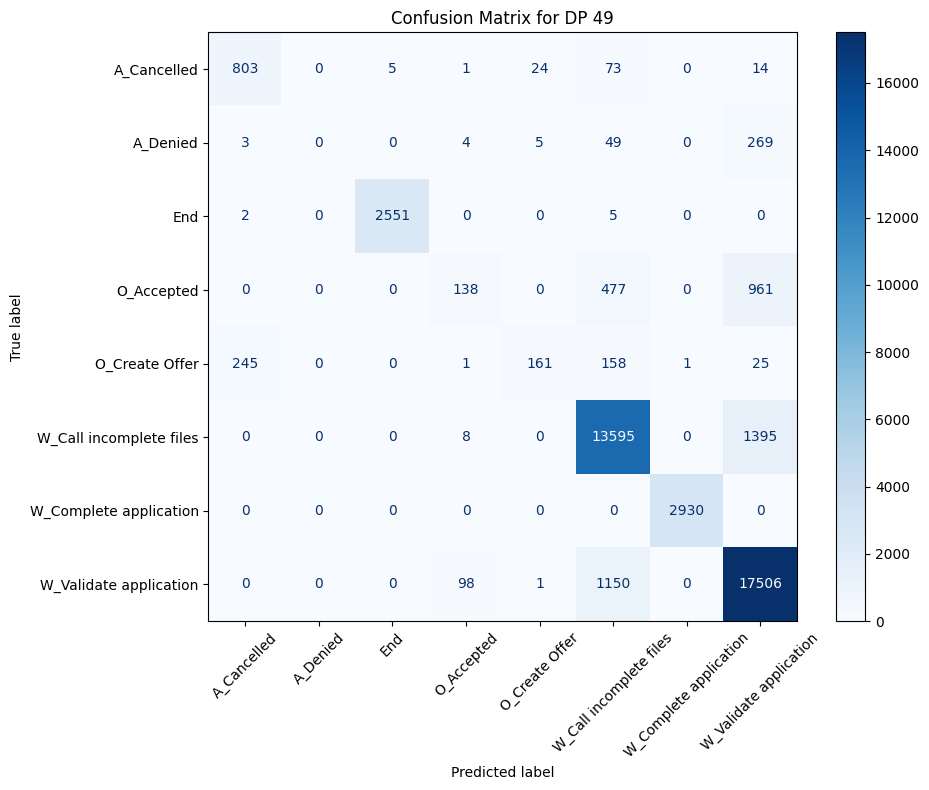

In [19]:
# Step: Build holdout data dict from dp_split_datasets
test_data_per_dp = {
    dp_name: splits["holdout"]
    for dp_name, splits in dp_split_datasets_full_advanced.items()
    if "holdout" in splits and not splits["holdout"].empty
}

# Step: Run evaluation using your existing function
for dp in test_data_per_dp.keys():
    compare_f1_for_trained_model(dp, test_data_per_dp, models_advanced_holdout)

## 1.7 Final Permutation Importance

## 1.8 Evaluation Plots and Metrics

In [27]:
# --- Per-Decision Point Aggregates ---
dp_metrics_lstm = df_accuracy.groupby("decision_point").apply(
    lambda g: pd.Series({
        "precision": (g["precision"] * g["support"]).sum() / g["support"].sum(),
        "recall": (g["recall"] * g["support"]).sum() / g["support"].sum(),
        "f1_score": (g["f1_score"] * g["support"]).sum() / g["support"].sum()
    })
)

dp_metrics_baseline = df_baseline.groupby("decision_point").apply(
    lambda g: pd.Series({
        "precision": (g["precision"] * g["support"]).sum() / g["support"].sum(),
        "recall": (g["recall"] * g["support"]).sum() / g["support"].sum(),
        "f1_score": (g["f1_score"] * g["support"]).sum() / g["support"].sum()
    })
)


OUT_DIR = Path("../data/evaluation")
OUT_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(dp_metrics_lstm,     OUT_DIR / "dp_metrics_lstm_advanced.joblib")

/var/folders/ct/jknbc8jj3yb54ssrdbml90z00000gn/T/ipykernel_63608/1279891679.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dp_metrics_lstm = df_accuracy.groupby("decision_point").apply(
/var/folders/ct/jknbc8jj3yb54ssrdbml90z00000gn/T/ipykernel_63608/1279891679.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dp_metrics_baseline = df_baseline.groupby("decision_point").apply(


['../data/evaluation/dp_metrics_lstm_advanced.joblib']

In [28]:
# --- Mean and Std per model ---
mean_precision_lstm = dp_metrics_lstm["precision"].mean()
std_precision_lstm = dp_metrics_lstm["precision"].std()

mean_recall_lstm = dp_metrics_lstm["recall"].mean()
std_recall_lstm = dp_metrics_lstm["recall"].std()

mean_f1_lstm = dp_metrics_lstm["f1_score"].mean()
std_f1_lstm = dp_metrics_lstm["f1_score"].std()

mean_precision_baseline = dp_metrics_baseline["precision"].mean()
std_precision_baseline = dp_metrics_baseline["precision"].std()

mean_recall_baseline = dp_metrics_baseline["recall"].mean()
std_recall_baseline = dp_metrics_baseline["recall"].std()

mean_f1_baseline = dp_metrics_baseline["f1_score"].mean()
std_f1_baseline = dp_metrics_baseline["f1_score"].std()

# --- Print Global + Std ---
print("\n=== Aggregated Across Decision Points ===")
print(f"Precision (LSTM):     {mean_precision_lstm:.3f} ± {std_precision_lstm:.3f}")
print(f"Precision (Baseline): {mean_precision_baseline:.3f} ± {std_precision_baseline:.3f}\n")

print(f"Recall (LSTM):        {mean_recall_lstm:.3f} ± {std_recall_lstm:.3f}")
print(f"Recall (Baseline):    {mean_recall_baseline:.3f} ± {std_recall_baseline:.3f}\n")

print(f"F1-score (LSTM):      {mean_f1_lstm:.3f} ± {std_f1_lstm:.3f}")
print(f"F1-score (Baseline):  {mean_f1_baseline:.3f} ± {std_f1_baseline:.3f}")


=== Aggregated Across Decision Points ===
Precision (LSTM):     88.536 ± 6.556
Precision (Baseline): 49.392 ± 18.730

Recall (LSTM):        90.365 ± 5.555
Recall (Baseline):    49.363 ± 18.671

F1-score (LSTM):      88.703 ± 6.415
F1-score (Baseline):  49.376 ± 18.701


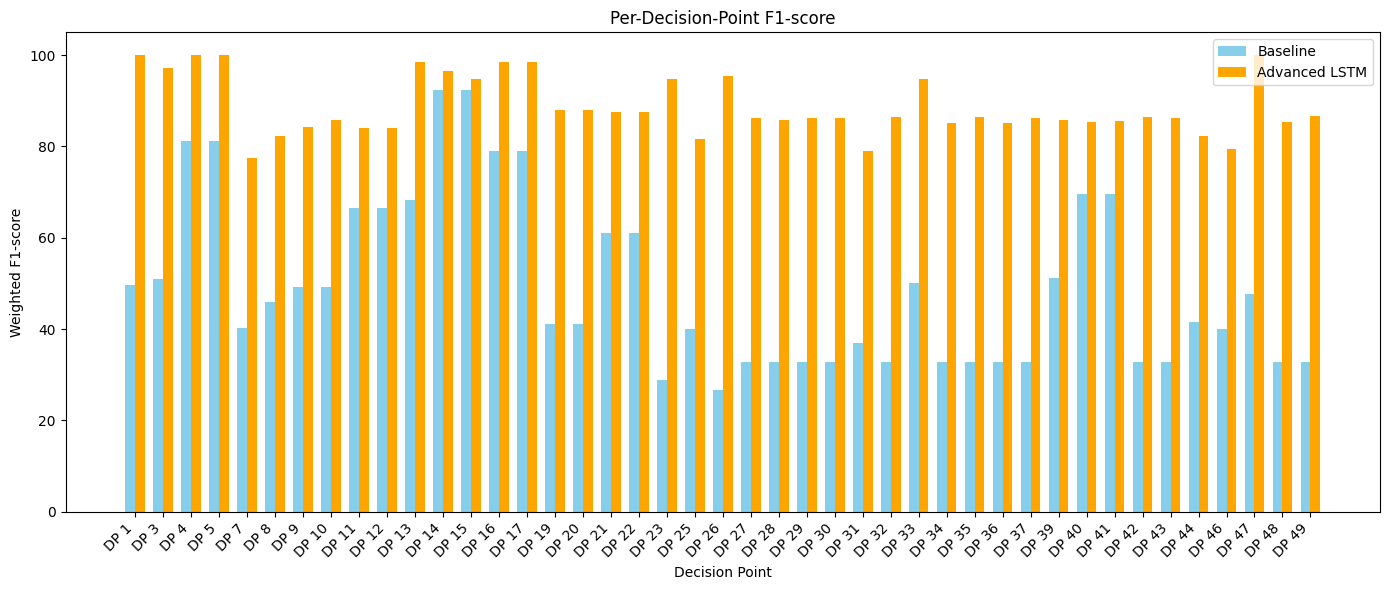

In [30]:
# Combine metrics
dp_metrics = pd.DataFrame({
    "baseline_f1": dp_metrics_baseline["f1_score"],
    "lstm_f1": dp_metrics_lstm["f1_score"]
})

# Extract numeric part for sorting
def extract_dp_number(dp_name):
    match = re.search(r'\d+', dp_name)
    return int(match.group()) if match else float('inf')

dp_metrics["dp_number"] = dp_metrics.index.map(extract_dp_number)
dp_metrics = dp_metrics.sort_values("dp_number")

# Plot
x = np.arange(len(dp_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, dp_metrics["baseline_f1"], width, label="Baseline", color="skyblue")
bars2 = ax.bar(x + width/2, dp_metrics["lstm_f1"], width, label="Advanced LSTM", color="orange")

ax.set_xlabel("Decision Point")
ax.set_ylabel("Weighted F1-score")
ax.set_title("Per-Decision-Point F1-score")
ax.set_xticks(x)
ax.set_xticklabels(dp_metrics.index, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

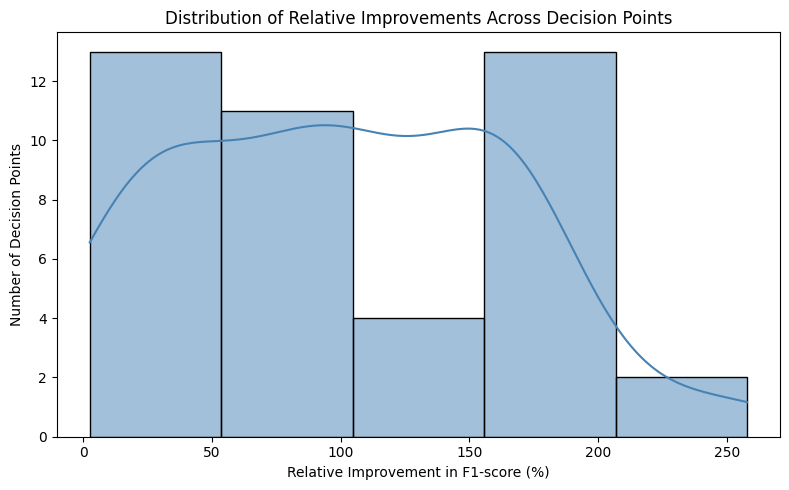

In [31]:
# Calculate %ΔF1 for each decision point
relative_improvement_f1_dp = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"])
    / dp_metrics_baseline["f1_score"] * 100
)

# Plot histogram + KDE
plt.figure(figsize=(8, 5))
sns.histplot(relative_improvement_f1_dp, bins=5, kde=True, color="steelblue", edgecolor="black")

# Labels and title
plt.xlabel("Relative Improvement in F1-score (%)")
plt.ylabel("Number of Decision Points")
plt.title("Distribution of Relative Improvements Across Decision Points")

plt.tight_layout()
plt.show()

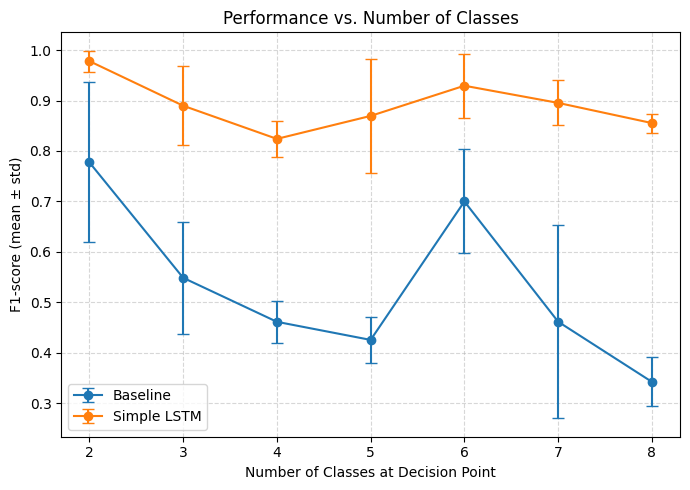

In [32]:
# --- 1. Get number of classes per decision point ---
num_classes_per_dp = (
    df_accuracy.groupby("decision_point")["label"]
    .nunique()
    .reset_index()
    .rename(columns={"label": "num_classes"})
)

# --- 2. Merge per-DP metrics with number of classes ---
dp_perf = pd.merge(
    dp_metrics_lstm.reset_index(),
    dp_metrics_baseline.reset_index(),
    on="decision_point",
    suffixes=("_lstm", "_baseline")
)
dp_perf = pd.merge(dp_perf, num_classes_per_dp, on="decision_point")

# --- 3. Convert percentage values to fraction scale ---
metric_cols = ["precision_lstm", "recall_lstm", "f1_score_lstm",
               "precision_baseline", "recall_baseline", "f1_score_baseline"]

for col in metric_cols:
    if dp_perf[col].max() > 1:  # Means it's in percentage
        dp_perf[col] = dp_perf[col] / 100.0

# --- 4. Group by num_classes and calculate mean & std (numeric only) ---
grouped = dp_perf.groupby("num_classes")[metric_cols].agg(["mean", "std"])

# --- 5. Plot Baseline vs LSTM F1-score with error bars ---
plt.figure(figsize=(7, 5))
plt.errorbar(
    grouped.index, grouped["f1_score_baseline"]["mean"],
    yerr=grouped["f1_score_baseline"]["std"],
    fmt='o-', capsize=4, label="Baseline"
)
plt.errorbar(
    grouped.index, grouped["f1_score_lstm"]["mean"],
    yerr=grouped["f1_score_lstm"]["std"],
    fmt='o-', capsize=4, label="Simple LSTM"
)

plt.xlabel("Number of Classes at Decision Point")
plt.ylabel("F1-score (mean ± std)")
plt.title("Performance vs. Number of Classes")
plt.xticks(grouped.index)  # Show exact class counts on x-axis
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

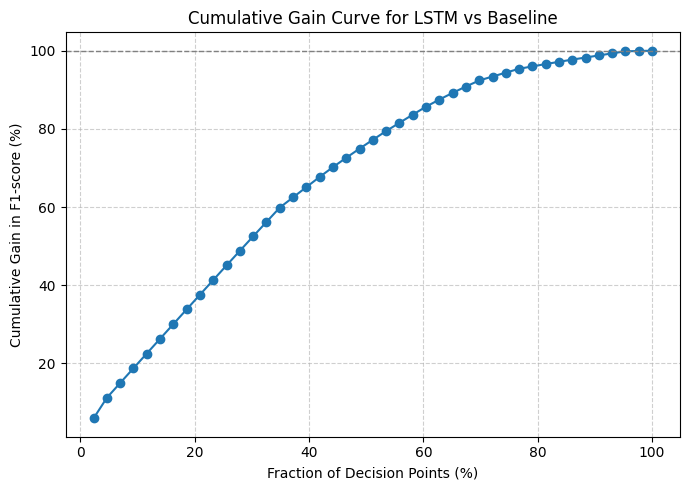

In [33]:
# --- 1. Calculate %ΔF1 per DP ---
dp_improvement = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"]) /
    dp_metrics_baseline["f1_score"] * 100
).sort_values(ascending=False)

# --- 2. Compute cumulative sum (normalized to 100%) ---
cumulative_gain = dp_improvement.cumsum()
cumulative_gain_normalized = cumulative_gain / cumulative_gain.iloc[-1] * 100

# --- 3. X-axis: fraction of decision points ---
dp_fraction = np.arange(1, len(dp_improvement) + 1) / len(dp_improvement) * 100

# --- 4. Plot ---
plt.figure(figsize=(7, 5))
plt.plot(dp_fraction, cumulative_gain_normalized, marker="o")
plt.axhline(100, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Fraction of Decision Points (%)")
plt.ylabel("Cumulative Gain in F1-score (%)")
plt.title("Cumulative Gain Curve for LSTM vs Baseline")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

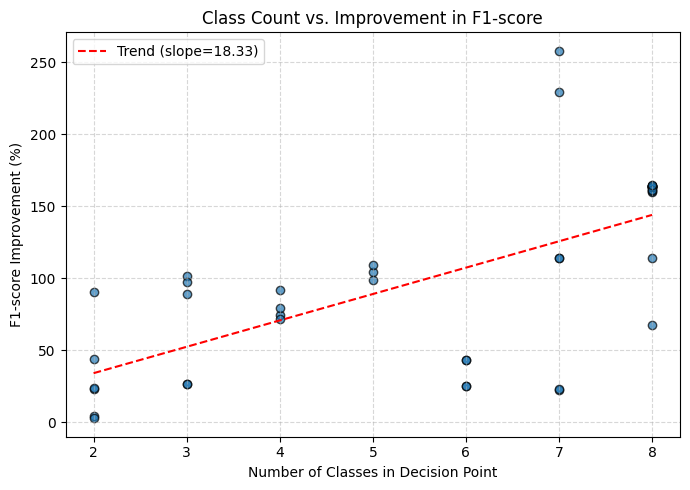

In [34]:
# --- 1. Calculate %ΔF1 per DP ---
dp_improvement = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"]) /
    dp_metrics_baseline["f1_score"] * 100
)

# --- 2. Get number of classes per DP ---
num_classes_per_dp = df_accuracy.groupby("decision_point")["label"].nunique()

# Align with dp_improvement index
num_classes_per_dp = num_classes_per_dp.loc[dp_improvement.index]

# --- 3. Scatter plot ---
plt.figure(figsize=(7, 5))
plt.scatter(num_classes_per_dp, dp_improvement, alpha=0.7, edgecolor="black")

# --- 4. Fit regression line ---
coef = np.polyfit(num_classes_per_dp, dp_improvement, 1)
poly1d_fn = np.poly1d(coef)
x_vals = np.linspace(num_classes_per_dp.min(), num_classes_per_dp.max(), 100)
plt.plot(x_vals, poly1d_fn(x_vals), color="red", linestyle="--", label=f"Trend (slope={coef[0]:.2f})")

# --- 5. Labels & formatting ---
plt.xlabel("Number of Classes in Decision Point")
plt.ylabel("F1-score Improvement (%)")
plt.title("Class Count vs. Improvement in F1-score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 1.9 Final Training & Storage

In [ ]:
# --- Storage ---
final_models_trained_on_full_data = {}

# Loop over all decision points
for dp_name in df_hyperparams_summary.index:
    print(f"\nRetraining on FULL dataset for: {dp_name}")

    try:
        # Get all data splits
        splits = dp_split_datasets_full_advanced.get(dp_name)
        if not splits:
            print(f"No data available for {dp_name}")
            continue

        # Combine all data: train + test + holdout
        df_full = pd.concat([splits["train"], splits["test"], splits["holdout"]], ignore_index=True)

        # Prepare inputs
        X_acts, X_durs, X_res, act_enc, res_enc, label_enc, y_full, max_seq_len = prepare_sequences_and_labels(df_full)
        X_ctx, context_dim, context_encoders = prepare_context_attributes(df_full, context_keys_advanced)

        # Add "UNKNOWN" to all label encoders (if not already present)
        def ensure_unknown(encoder):
            if "UNKNOWN" not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, "UNKNOWN")

        ensure_unknown(act_enc)
        ensure_unknown(res_enc)
        ensure_unknown(label_enc)
        for enc in context_encoders.values():
            if isinstance(enc, LabelEncoder):
                ensure_unknown(enc)

        # Get hyperparameters
        params = df_hyperparams_summary.loc[dp_name]
        embedding_dim = int(params["embedding_dim"])
        lstm_units = int(params["lstm_units"])
        dropout_rate = float(params["dropout_rate"])
        learning_rate = float(params["learning_rate"])
        num_classes = len(label_enc.classes_)

        # Build model
        model = build_lstm_model_advanced(
            num_activities=len(act_enc.classes_),
            num_resources=len(res_enc.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=num_classes,
            embedding_dim=embedding_dim,
            lstm_units=lstm_units,
            dropout_rate=dropout_rate
        )

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        train_model_advanced(model, [X_acts, X_durs, X_res, X_ctx], y_full)

        # Store model and encoders
        final_models_trained_on_full_data[dp_name] = {
            "model": model,
            "label_encoder": label_enc,
            "activity_encoder": act_enc,
            "resource_encoder": res_enc,
            "context_dim": context_dim,
            "context_encoders": context_encoders,
            "context_keys": context_keys_advanced,
            "max_seq_len": max_seq_len
        }

        print(f"Successfully trained final model for {dp_name}")

    except Exception as e:
        print(f"Error while retraining {dp_name}: {e}")

In [ ]:
# Go up from notebooks/ to project root, then into models/models_advanced
save_dir = os.path.join("..", "models", "models_advanced")
os.makedirs(save_dir, exist_ok=True)

for dp_name, data in final_models_trained_on_full_data.items():
    dp_path = os.path.join(save_dir, dp_name)
    os.makedirs(dp_path, exist_ok=True)

    # Save model
    model_path = os.path.join(dp_path, "model.keras")
    data["model"].save(model_path)

    # Save encoders
    joblib.dump(data["activity_encoder"], os.path.join(dp_path, "activity_encoder.pkl"))
    joblib.dump(data["resource_encoder"], os.path.join(dp_path, "resource_encoder.pkl"))
    joblib.dump(data["label_encoder"], os.path.join(dp_path, "label_encoder.pkl"))
    joblib.dump(data["context_encoders"], os.path.join(dp_path, "context_encoders.pkl"))

    # Save metadata
    metadata = {
        "context_keys": data["context_keys"],
        "max_seq_len": data["max_seq_len"]
    }
    joblib.dump(metadata, os.path.join(dp_path, "metadata.pkl"))

print(f"Saved models to {os.path.abspath(save_dir)}")